In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

## Dataset preparation and preprocessing

In [ ]:
import pandas as pd
import numpy as np

# Load the datasets
freetext_data = pd.read_csv('/content/drive/MyDrive/Security_project/free-text.csv', low_memory=False)
demographics_data = pd.read_csv('/content/drive/MyDrive/Security_project/demographics.csv')

# Remove unnecessary columns
freetext_data = freetext_data.drop(columns=['Unnamed: 9'], errors='ignore')

# Merge freetext_data with demographics_data
merged_data = freetext_data.merge(demographics_data, on='participant', how='left')

# Remove leading/trailing whitespace from column names
merged_data.columns = merged_data.columns.str.strip()

# List of keystroke timing features
keystroke_features = ['DU.key1.key1', 'DD.key1.key2', 'DU.key1.key2', 'UD.key1.key2', 'UU.key1.key2']

# Drop rows with missing values in keystroke columns
merged_data = merged_data.dropna(subset=keystroke_features)

# Clean Data Function
def clean_data(df):
    # Convert relevant columns to numeric, forcing any non-convertible values to NaN
    df['DU.key1.key1'] = pd.to_numeric(df['DU.key1.key1'], errors='coerce')

    # Fill NaN values with the column mean for each feature
    df[keystroke_features] = df[keystroke_features].apply(lambda x: x.fillna(x.mean()), axis=0)

    # Replace inf values with the maximum finite value in the dataset for each feature
    for col in keystroke_features:
        finite_max = df[np.isfinite(df[col])][col].max()  # Max finite value in the column
        df[col] = df[col].replace([np.inf, -np.inf], finite_max)

    return df

# Apply the cleaning function to the merged data
merged_data = clean_data(merged_data)

# Display first few rows of the cleaned merged data
print("Cleaned Merged Data Sample:")
merged_data.head()

Cleaned Merged Data Sample:


,participant,session,key1,key2,DU.key1.key1,DD.key1.key2,DU.key1.key2,UD.key1.key2,UU.key1.key2,handedness,age,gender,nationality
0,p001,1,W,Shift,0.150,-0.796,0.166,-0.946,0.016,Right-Handed,51,Male,Portugal
1,p001,1,Shift,e,0.962,1.148,1.255,0.186,0.293,Right-Handed,51,Male,Portugal
2,p001,1,e,Space,0.107,0.172,0.252,0.065,0.145,Right-Handed,51,Male,Portugal
3,p001,1,Space,b,0.080,0.200,0.280,0.120,0.200,Right-Handed,51,Male,Portugal
4,p001,1,b,e,0.080,0.320,0.480,0.240,0.400,Right-Handed,51,Male,Portugal


## Feature Engineering

In [ ]:
# List of keystroke timing features
keystroke_features = ['DU.key1.key1', 'DD.key1.key2', 'DU.key1.key2', 'UD.key1.key2', 'UU.key1.key2']

# Calculate the mean profile for each participant
user_baselines = merged_data.groupby('participant')[keystroke_features].mean()

# Display the user baseline for reference
print("User-Specific Baselines:")
user_baselines.head()


User-Specific Baselines:


,DU.key1.key1,DD.key1.key2,DU.key1.key2,UD.key1.key2,UU.key1.key2
participant,,,,,
p001,0.106501,0.313135,0.419588,0.206635,0.313088
p002,0.087517,0.176844,0.264273,0.089326,0.176756
p003,0.184584,0.142621,0.327193,-0.041964,0.142609
p004,0.578485,0.177597,0.795602,-0.400888,0.217117
p005,0.105231,0.318274,0.423303,0.213101,0.318089


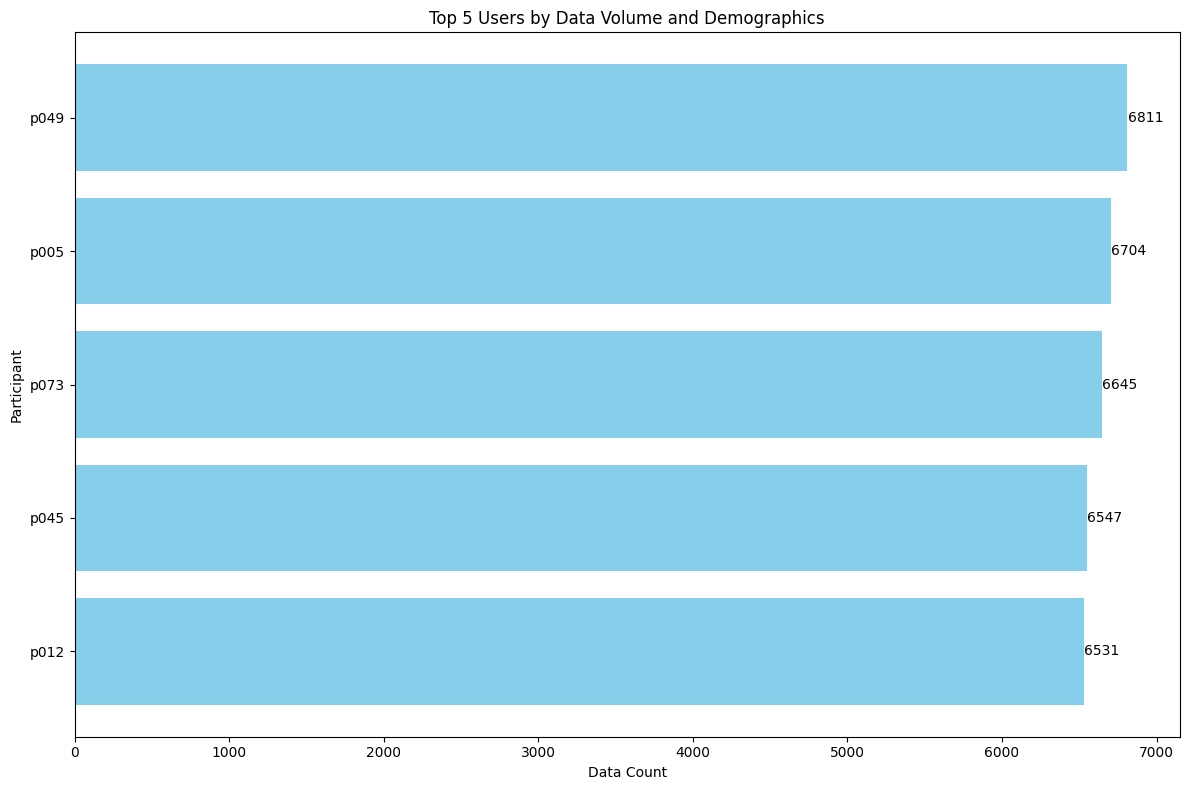

In [ ]:
import matplotlib.pyplot as plt

# Group by 'participant' to get demographic diversity and data volume per user
user_summary = merged_data.groupby('participant').agg(
    age=('age', 'first'),
    gender=('gender', 'first'),
    handedness=('handedness', 'first'),
    nationality=('nationality', 'first'),
    data_count=('participant', 'size')  # Number of records per user
).reset_index()

# Sort users by data volume in descending order to prioritize users with more samples
user_summary_sorted = user_summary.sort_values(by='data_count', ascending=False)

# Horizontal bar chart for top 10 users by data count
plt.figure(figsize=(12, 8))
top_users = user_summary_sorted.head(5)
plt.barh(top_users['participant'], top_users['data_count'], color='skyblue')
plt.gca().invert_yaxis()

# Annotate bars with data count values
for index, value in enumerate(top_users['data_count']):
    plt.text(value + 1, index, str(value), va='center', fontsize=10)

plt.xlabel('Data Count')  # Label for x-axis
plt.ylabel('Participant')  # Label for y-axis
plt.title('Top 5 Users by Data Volume and Demographics')  # Title for the chart
plt.tight_layout()  # Adjust layout for better fit
plt.show()


In [ ]:
# Select top 5 users based on diversity in age, gender, handedness, and data count
selected_users = user_summary_sorted['participant'].head(5).values
print("Selected Participants:", selected_users)

Selected Participants: ['p049' 'p005' 'p073' 'p045' 'p012']


# Distance-Based Similarity Measures

## Euclidean vs Mahalanobis

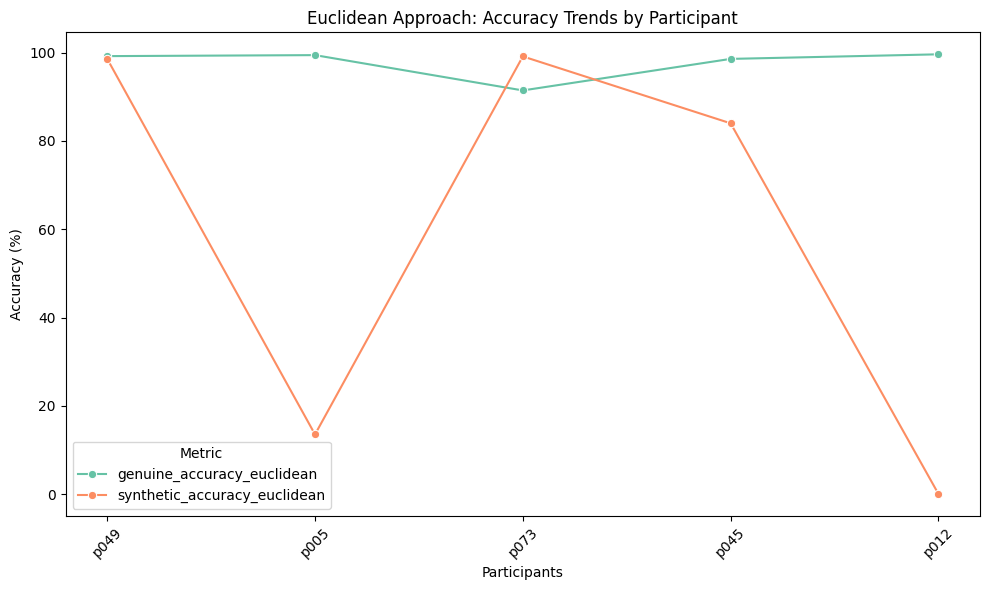

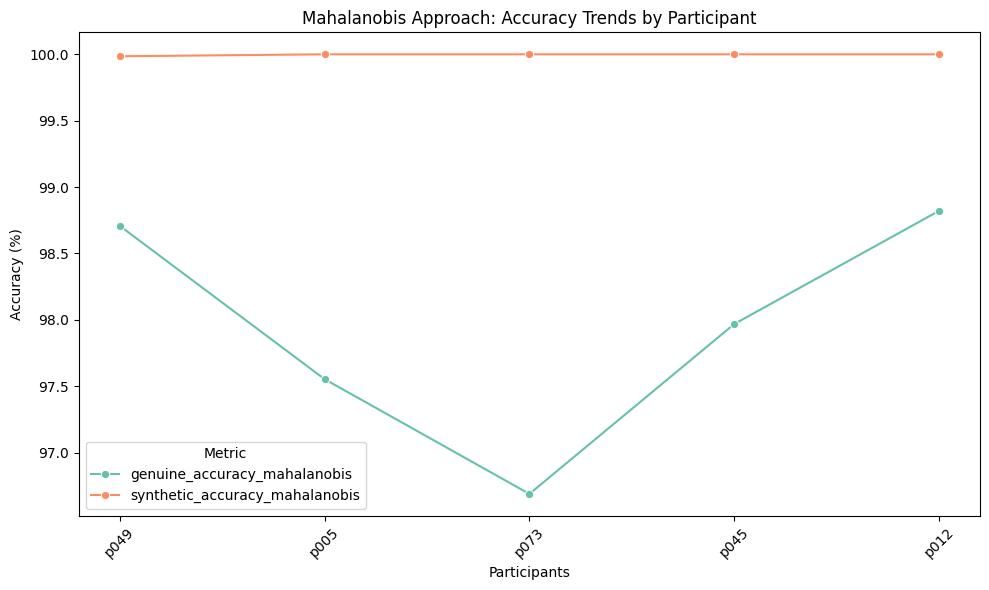

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean, mahalanobis
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Distance Calculation Methods
# ---------------------------
def calculate_euclidean(sample, baseline):
    """
    Calculate Euclidean distance.
    """
    return euclidean(sample, baseline)

def calculate_mahalanobis(sample, baseline, inv_cov_matrix):
    """
    Calculate Mahalanobis distance.
    """
    return mahalanobis(sample, baseline, inv_cov_matrix)

# ---------------------------
# Synthetic Data Generation
# ---------------------------
def generate_synthetic_data(data):
    """
    Generate synthetic data by sampling from a normal distribution.
    """
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    return np.random.normal(mean, std_dev, data.shape)

def get_invertible_cov_matrix(data):
    """
    Obtain an invertible covariance matrix by adding regularization.
    """
    cov_matrix = np.cov(data, rowvar=False)
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-5  # Regularization
    return np.linalg.inv(cov_matrix)

# ---------------------------
# Authentication Evaluation
# ---------------------------
def test_user_authentication(participant_data, baseline, inv_cov_matrix, technique, thresholds):
    """
    Evaluate authentication for a participant using a specified technique.
    """
    results = []
    for sample in participant_data:
        if technique == "Euclidean":
            dist = calculate_euclidean(sample, baseline)
            is_impostor = dist > thresholds['euclidean']
        elif technique == "Mahalanobis":
            dist = calculate_mahalanobis(sample, baseline, inv_cov_matrix)
            is_impostor = dist > thresholds['mahalanobis']
        results.append(is_impostor)
    return results

# ---------------------------
# Evaluation Workflow
# ---------------------------
def evaluate_authentication_single_row(data, keystroke_features, selected_users):
    """
    Evaluate authentication using different approaches and return results.
    """
    results = []
    thresholds = {'euclidean': 2.0, 'mahalanobis': 3.5}

    for user in selected_users:
        user_data = data[data['participant'] == user][keystroke_features].values
        baseline = user_data.mean(axis=0)
        inv_cov_matrix = get_invertible_cov_matrix(user_data)

        # Genuine Data Evaluation (Euclidean)
        genuine_results_euclidean = test_user_authentication(user_data, baseline, inv_cov_matrix, "Euclidean", thresholds)
        genuine_accuracy_euclidean = genuine_results_euclidean.count(False) / len(genuine_results_euclidean) * 100

        # Genuine Data Evaluation (Mahalanobis)
        genuine_results_mahalanobis = test_user_authentication(user_data, baseline, inv_cov_matrix, "Mahalanobis", thresholds)
        genuine_accuracy_mahalanobis = genuine_results_mahalanobis.count(False) / len(genuine_results_mahalanobis) * 100

        # Synthetic Data Evaluation (Euclidean)
        synthetic_data_euclidean = generate_synthetic_data(user_data)
        synthetic_results_euclidean = test_user_authentication(synthetic_data_euclidean, baseline, inv_cov_matrix, "Euclidean", thresholds)
        synthetic_accuracy_euclidean = synthetic_results_euclidean.count(True) / len(synthetic_results_euclidean) * 100

        # Synthetic Data Evaluation (Mahalanobis)
        synthetic_data_mahalanobis = generate_synthetic_data(user_data)
        synthetic_results_mahalanobis = test_user_authentication(synthetic_data_mahalanobis, baseline, inv_cov_matrix, "Mahalanobis", thresholds)
        synthetic_accuracy_mahalanobis = synthetic_results_mahalanobis.count(True) / len(synthetic_results_mahalanobis) * 100

        # Append Results
        results.append({
            'participant': user,
            'genuine_accuracy_euclidean': genuine_accuracy_euclidean,
            'synthetic_accuracy_euclidean': synthetic_accuracy_euclidean,
            'genuine_accuracy_mahalanobis': genuine_accuracy_mahalanobis,
            'synthetic_accuracy_mahalanobis': synthetic_accuracy_mahalanobis
        })

    return pd.DataFrame(results)

# ---------------------------
# Run the Evaluation
# ---------------------------
results_df = evaluate_authentication_single_row(merged_data, keystroke_features, selected_users)

# ---------------------------
# Visualization for Euclidean
# ---------------------------
euclidean_data = results_df[['participant', 'genuine_accuracy_euclidean', 'synthetic_accuracy_euclidean']]
euclidean_data = euclidean_data.melt(id_vars='participant', var_name='Metric', value_name='Accuracy')
euclidean_data

# Line Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=euclidean_data, x='participant', y='Accuracy', hue='Metric', marker='o', palette='Set2')
plt.title("Euclidean Approach: Accuracy Trends by Participant")
plt.xlabel("Participants")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # ---------------------------
# # Visualization for Mahalanobis
# # ---------------------------
mahalanobis_data = results_df[['participant', 'genuine_accuracy_mahalanobis', 'synthetic_accuracy_mahalanobis']]
mahalanobis_data = mahalanobis_data.melt(id_vars='participant', var_name='Metric', value_name='Accuracy')

# Line Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=mahalanobis_data, x='participant', y='Accuracy', hue='Metric', marker='o', palette='Set2')
plt.title("Mahalanobis Approach: Accuracy Trends by Participant")
plt.xlabel("Participants")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Average EER Results Across All Users:
      Approach       EER  Threshold
0    Euclidean  0.135147   0.862819
1  Mahalanobis  0.001519  15.695114


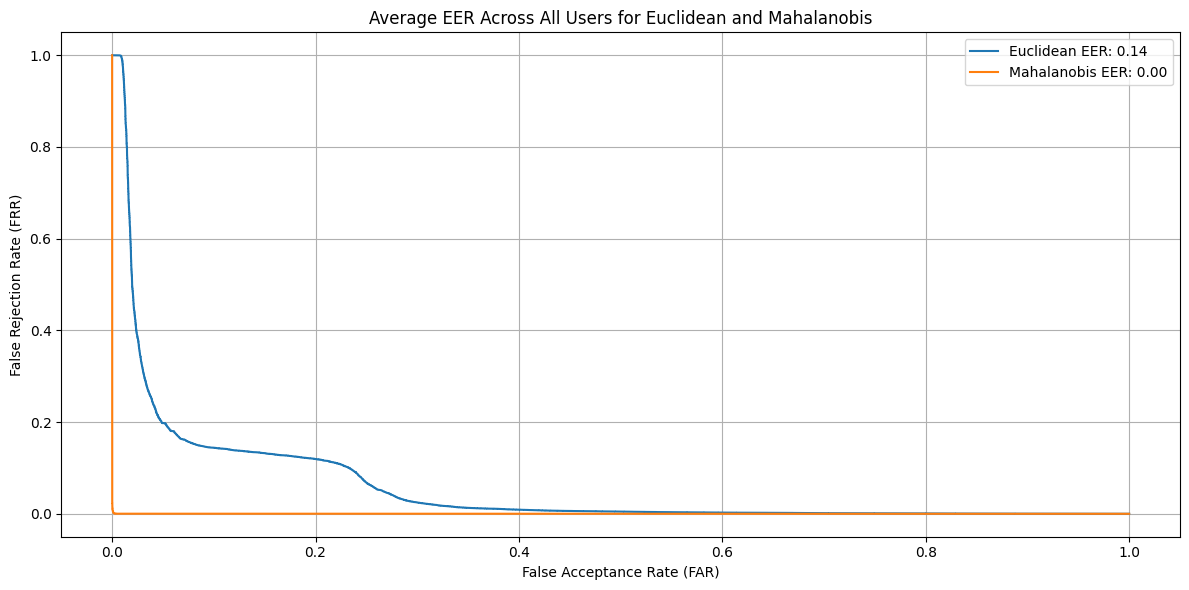

In [ ]:
from sklearn.metrics import roc_curve

# ---------------------------
# EER Calculation Function
# ---------------------------
def calculate_eer(distances, labels):
    """
    Calculate the Equal Error Rate (EER) and the corresponding threshold.
    :param distances: Array of distances calculated for genuine and imposter samples
    :param labels: Array of true labels (1 for genuine, 0 for imposter)
    :return: EER, threshold, FAR, FRR
    """
    # Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
    fpr, tpr, thresholds = roc_curve(labels, distances, pos_label=0)

    # FRR = 1 - TPR
    frr = 1 - tpr

    # Find the threshold where FAR and FRR are closest
    eer_index = np.nanargmin(np.abs(fpr - frr))
    eer = (fpr[eer_index] + frr[eer_index]) / 2

    return eer, thresholds[eer_index], fpr, frr
# ---------------------------
# EER for Average Across All Participants
# ---------------------------
def evaluate_average_eer(data, keystroke_features, selected_users):
    """
    Calculate average EER across all users for Euclidean and Mahalanobis approaches.
    """
    all_genuine_distances_euclidean = []
    all_impostor_distances_euclidean = []

    all_genuine_distances_mahalanobis = []
    all_impostor_distances_mahalanobis = []

    for user in selected_users:
        user_data = data[data['participant'] == user][keystroke_features].values
        baseline = user_data.mean(axis=0)
        inv_cov_matrix = get_invertible_cov_matrix(user_data)

        # Genuine distances
        for sample in user_data:
            all_genuine_distances_euclidean.append(calculate_euclidean(sample, baseline))
            all_genuine_distances_mahalanobis.append(calculate_mahalanobis(sample, baseline, inv_cov_matrix))

        # Impostor distances
        synthetic_data = generate_synthetic_data(user_data)
        for sample in synthetic_data:
            all_impostor_distances_euclidean.append(calculate_euclidean(sample, baseline))
            all_impostor_distances_mahalanobis.append(calculate_mahalanobis(sample, baseline, inv_cov_matrix))

    # Combine distances and labels
    distances_euclidean = np.concatenate([all_genuine_distances_euclidean, all_impostor_distances_euclidean])
    labels_euclidean = np.concatenate([np.ones(len(all_genuine_distances_euclidean)), np.zeros(len(all_impostor_distances_euclidean))])

    distances_mahalanobis = np.concatenate([all_genuine_distances_mahalanobis, all_impostor_distances_mahalanobis])
    labels_mahalanobis = np.concatenate([np.ones(len(all_genuine_distances_mahalanobis)), np.zeros(len(all_impostor_distances_mahalanobis))])

    # Calculate EER for Euclidean
    euclidean_eer, euclidean_threshold, euclidean_fpr, euclidean_frr = calculate_eer(distances_euclidean, labels_euclidean)

    # Calculate EER for Mahalanobis
    mahalanobis_eer, mahalanobis_threshold, mahalanobis_fpr, mahalanobis_frr = calculate_eer(distances_mahalanobis, labels_mahalanobis)

    return {
        "euclidean_eer": euclidean_eer,
        "euclidean_threshold": euclidean_threshold,
        "mahalanobis_eer": mahalanobis_eer,
        "mahalanobis_threshold": mahalanobis_threshold,
        "euclidean_fpr": euclidean_fpr,
        "euclidean_frr": euclidean_frr,
        "mahalanobis_fpr": mahalanobis_fpr,
        "mahalanobis_frr": mahalanobis_frr
    }

# ---------------------------
# Calculate Average EER
# ---------------------------
average_eer_results = evaluate_average_eer(merged_data, keystroke_features, selected_users)

# Display Results Table
results_table = pd.DataFrame([{
    "Approach": "Euclidean",
    "EER": average_eer_results["euclidean_eer"],
    "Threshold": average_eer_results["euclidean_threshold"]
}, {
    "Approach": "Mahalanobis",
    "EER": average_eer_results["mahalanobis_eer"],
    "Threshold": average_eer_results["mahalanobis_threshold"]
}])

print("Average EER Results Across All Users:")
print(results_table)

# ---------------------------
# Visualization for Average EER
# ---------------------------
plt.figure(figsize=(12, 6))

# Plot ROC for Euclidean
plt.plot(average_eer_results["euclidean_fpr"], average_eer_results["euclidean_frr"], label=f"Euclidean EER: {average_eer_results['euclidean_eer']:.2f}")

# Plot ROC for Mahalanobis
plt.plot(average_eer_results["mahalanobis_fpr"], average_eer_results["mahalanobis_frr"], label=f"Mahalanobis EER: {average_eer_results['mahalanobis_eer']:.2f}")

plt.title("Average EER Across All Users for Euclidean and Mahalanobis")
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("False Rejection Rate (FRR)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Traditonal Anamoly Detection approaches

## One-class SVM vs LOF vs Isolation Forest

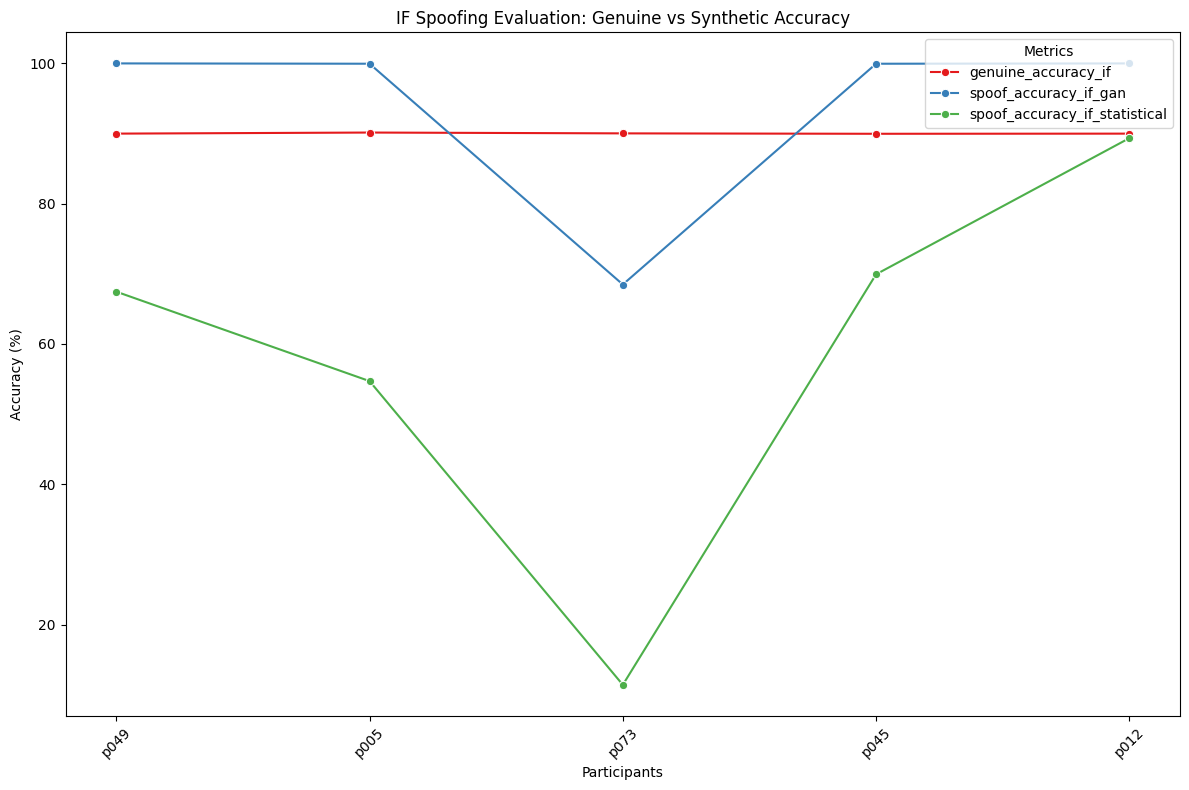

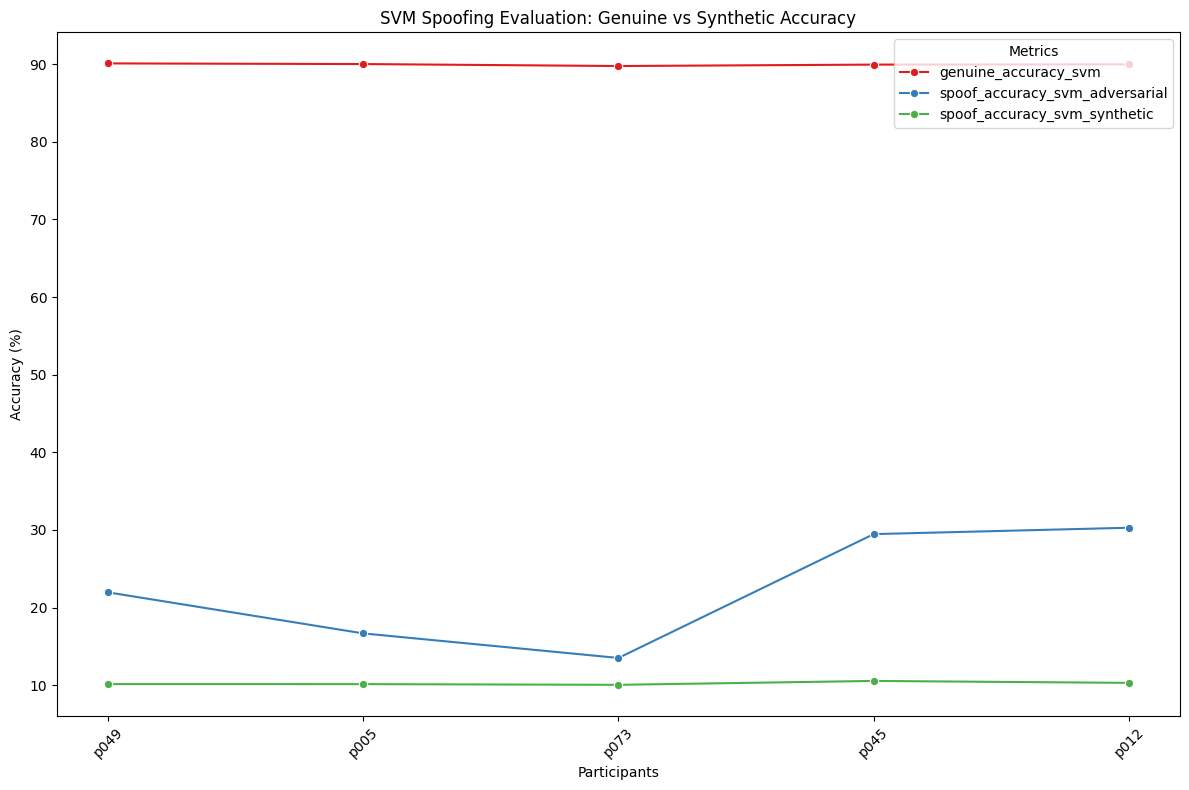

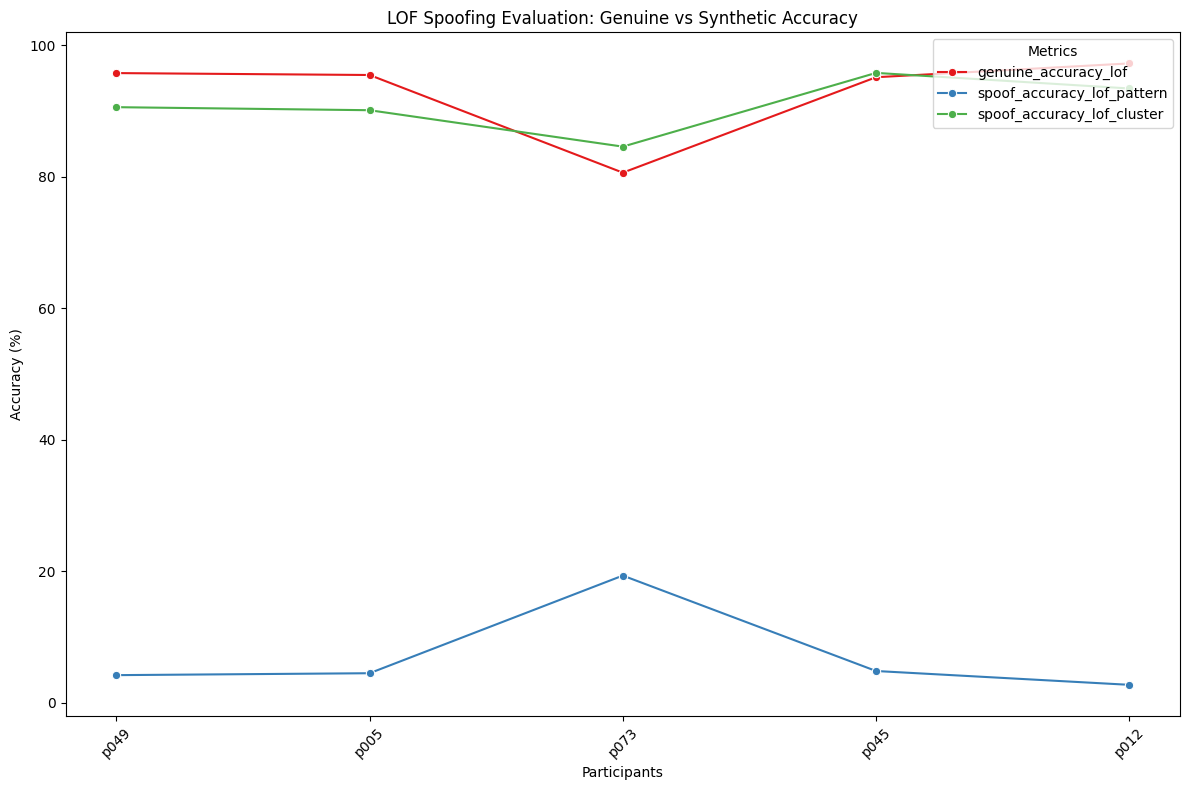

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Spoofing Techniques
# ---------------------------
def gan_based_spoofing(data, generator=None):
    """
    Generate GAN-based spoofed data.
    """
    noise = np.random.normal(0, 1, (len(data), data.shape[1]))
    if generator:
        return generator.predict(noise)
    else:
        return data + noise  # Default behavior if no generator provided

def adversarial_perturbation(data, epsilon=0.1):
    """
    Add adversarial perturbations to the data.
    """
    perturbation = epsilon * np.sign(np.random.normal(0, 1, data.shape))
    return data + perturbation

def synthetic_data_perturbation(data):
    """
    Generate synthetic data with slight perturbations.
    """
    return data + np.random.normal(0, 0.01, data.shape)

def statistical_sampling(data):
    """
    Create spoofed data using statistical sampling.
    """
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    return np.random.normal(mean, std_dev, data.shape)

def pattern_mimicking(data):
    """
    Create spoofed data by mimicking patterns of real data.
    """
    mimicked_data = np.copy(data)
    np.random.shuffle(mimicked_data)
    return mimicked_data

def cluster_shifting_spoofing(data):
    """
    Create spoofed data by shifting clusters slightly.
    """
    shift = np.random.uniform(-0.1, 0.1, data.shape)
    return data + shift

# ---------------------------
# Anomaly Detection Models
# ---------------------------
def fit_isolation_forest(train_data):
    model = IsolationForest(contamination=0.1, random_state=42)
    model.fit(train_data)
    return model

def fit_one_class_svm(train_data):
    model = OneClassSVM(kernel="rbf", gamma=0.1, nu=0.1)
    model.fit(train_data)
    return model

def fit_lof(train_data):
    model = LocalOutlierFactor(n_neighbors=20, novelty=True)
    model.fit(train_data)
    return model

# ---------------------------
# Evaluation with Cross-Validation
# ---------------------------
def evaluate_spoofing_with_folds(data, keystroke_features, selected_users, generator=None, n_folds=5):
    """
    Evaluate authentication methods using n-fold cross-validation against spoofing techniques.
    """
    results = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for user in selected_users:
        user_data = data[data['participant'] == user][keystroke_features].values
        fold_results = []

        for train_idx, test_idx in kf.split(user_data):
            train_data, test_data = user_data[train_idx], user_data[test_idx]

            # Fit Models
            isolation_forest = fit_isolation_forest(train_data)
            one_class_svm = fit_one_class_svm(train_data)
            lof = fit_lof(train_data)

            # Genuine Data Evaluation
            genuine_results_if = isolation_forest.predict(test_data)
            genuine_accuracy_if = list(genuine_results_if).count(1) / len(genuine_results_if) * 100

            genuine_results_svm = one_class_svm.predict(test_data)
            genuine_accuracy_svm = list(genuine_results_svm).count(1) / len(genuine_results_svm) * 100

            genuine_results_lof = lof.predict(test_data)
            genuine_accuracy_lof = list(genuine_results_lof).count(1) / len(genuine_results_lof) * 100

            # Spoofing Techniques
            spoofed_gan = gan_based_spoofing(test_data, generator)
            spoofed_adversarial = adversarial_perturbation(test_data)
            spoofed_pattern = pattern_mimicking(test_data)
            spoofed_cluster = cluster_shifting_spoofing(test_data)

            # Spoofing Data Evaluation
            spoof_accuracy_if_gan = list(isolation_forest.predict(spoofed_gan)).count(-1) / len(spoofed_gan) * 100
            spoof_accuracy_if_statistical = list(isolation_forest.predict(spoofed_adversarial)).count(-1) / len(spoofed_adversarial) * 100

            spoof_accuracy_svm_adversarial = list(one_class_svm.predict(spoofed_adversarial)).count(-1) / len(spoofed_adversarial) * 100
            spoof_accuracy_svm_synthetic = list(one_class_svm.predict(synthetic_data_perturbation(test_data))).count(-1) / len(test_data) * 100

            spoof_accuracy_lof_pattern = list(lof.predict(spoofed_pattern)).count(-1) / len(spoofed_pattern) * 100
            spoof_accuracy_lof_cluster = list(lof.predict(spoofed_cluster)).count(-1) / len(spoofed_cluster) * 100

            # Store fold results
            fold_results.append({
                'genuine_accuracy_if': genuine_accuracy_if,
                'spoof_accuracy_if_gan': spoof_accuracy_if_gan,
                'spoof_accuracy_if_statistical': spoof_accuracy_if_statistical,
                'genuine_accuracy_svm': genuine_accuracy_svm,
                'spoof_accuracy_svm_adversarial': spoof_accuracy_svm_adversarial,
                'spoof_accuracy_svm_synthetic': spoof_accuracy_svm_synthetic,
                'genuine_accuracy_lof': genuine_accuracy_lof,
                'spoof_accuracy_lof_pattern': spoof_accuracy_lof_pattern,
                'spoof_accuracy_lof_cluster': spoof_accuracy_lof_cluster
            })

        # Aggregate results over all folds
        average_results = pd.DataFrame(fold_results).mean().to_dict()
        average_results['participant'] = user
        results.append(average_results)

    return pd.DataFrame(results)

# ---------------------------
# Visualization Function
# ---------------------------
def visualize_results(results_df, method, spoofing_techniques):
    """
    Generate line plots for each authentication method and spoofing techniques.
    """
    # Extract relevant columns and melt data
    heatmap_data = results_df[['participant'] + spoofing_techniques]
    heatmap_melted = heatmap_data.melt(id_vars='participant', var_name='Metric', value_name='Accuracy')

    # Line Plot for Spoofing Evaluation
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=heatmap_melted, x='participant', y='Accuracy', hue='Metric', marker='o', palette='Set1')
    plt.title(f"{method.upper()} Spoofing Evaluation: Genuine vs Synthetic Accuracy")
    plt.xlabel("Participants")
    plt.ylabel("Accuracy (%)")
    plt.xticks(rotation=45)  # Rotate participant labels for better readability
    plt.legend(title="Metrics", loc="upper right")
    plt.tight_layout()
    plt.show()

# ---------------------------
# Run the Evaluation with n-folds
# ---------------------------
results_df = evaluate_spoofing_with_folds(
    data=merged_data,
    keystroke_features=keystroke_features,
    selected_users=selected_users,
    n_folds=5
)

# ---------------------------
# Visualizations
# ---------------------------
# Isolation Forest
visualize_results(results_df, 'if', ['genuine_accuracy_if', 'spoof_accuracy_if_gan', 'spoof_accuracy_if_statistical'])

# One-Class SVM
visualize_results(results_df, 'svm', ['genuine_accuracy_svm', 'spoof_accuracy_svm_adversarial', 'spoof_accuracy_svm_synthetic'])

# Local Outlier Factor
visualize_results(results_df, 'lof', ['genuine_accuracy_lof', 'spoof_accuracy_lof_pattern', 'spoof_accuracy_lof_cluster'])


Average EER Results Across All Users:
  Approach  EER  Threshold
0       IF  0.4          3
1      SVM  0.0          2
2      LOF  0.1          3


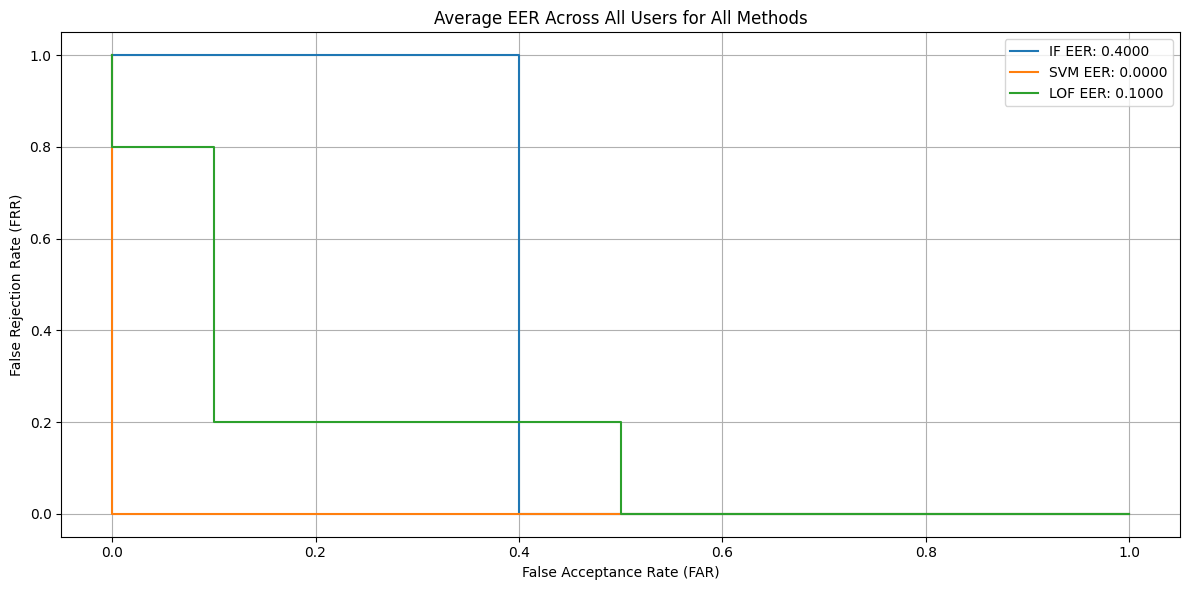

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Define Helper Functions
# ---------------------------
def calculate_eer(fpr, tpr):
    """Calculate Equal Error Rate (EER) given FPR and TPR."""
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fpr - fnr))  # Find the index of EER
    eer = fpr[eer_index]
    threshold = eer_index
    return eer, threshold

def calculate_average_eer(results_df, genuine_col, spoofing_cols):
    """
    Calculate EER for genuine and spoofing results averaged across all users.
    """
    # Combine genuine and spoof distances with labels
    genuine_distances = results_df[genuine_col].values
    spoof_distances = np.concatenate([results_df[col].values for col in spoofing_cols], axis=0)
    distances = np.concatenate([genuine_distances, spoof_distances])
    labels = np.concatenate([np.ones_like(genuine_distances), np.zeros_like(spoof_distances)])

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(labels, distances, pos_label=1)

    # Compute EER
    eer, threshold = calculate_eer(fpr, tpr)
    return eer, threshold, fpr, 1 - tpr

def evaluate_average_eer(results_df, method_config):
    """
    Evaluate average EER for all methods in the given results DataFrame.
    """
    eer_results = []
    for method, spoofing_cols in method_config.items():
        genuine_col = f"genuine_accuracy_{method}"
        if genuine_col not in results_df.columns:
            print(f"Warning: Genuine column {genuine_col} not found. Skipping {method}.")
            continue

        result = calculate_average_eer(results_df, genuine_col, spoofing_cols)
        if result is not None:
            eer, threshold, fpr, fnr = result
            eer_results.append({
                "Method": method.upper(),
                "EER": eer,
                "Threshold": threshold,
                "FPR": fpr,
                "FNR": fnr
            })
    return eer_results

# ---------------------------
# Run Average EER Calculation
# ---------------------------
method_config = {
    'if': ['spoof_accuracy_if_gan', 'spoof_accuracy_if_statistical'],
    'svm': ['spoof_accuracy_svm_adversarial', 'spoof_accuracy_svm_synthetic'],
    'lof': ['spoof_accuracy_lof_pattern', 'spoof_accuracy_lof_cluster']
}

average_eer_results = evaluate_average_eer(results_df, method_config)

# ---------------------------
# Prepare Results for Display
# ---------------------------
results_table = pd.DataFrame([
    {
        "Approach": result["Method"],
        "EER": result["EER"],
        "Threshold": result["Threshold"]
    } for result in average_eer_results
])

print("Average EER Results Across All Users:")
print(results_table)

# ---------------------------
# Visualization for Average EER
# ---------------------------
plt.figure(figsize=(12, 6))
for result in average_eer_results:
    plt.plot(result["FPR"], result["FNR"], label=f"{result['Method']} EER: {result['EER']:.4f}")

plt.title("Average EER Across All Users for All Methods")
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("False Rejection Rate (FRR)")
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


# Machine Learning Classifiers

## Random Forest vs SVM (RBF Kernel) vs Gradient Boosting

<ipython-input-7-a73df4319079>:101: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Security_project/free-text.csv')
<ipython-input-7-a73df4319079>:174: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=melted_data, x='Metric', y='Accuracy', marker='o', palette='Set2')


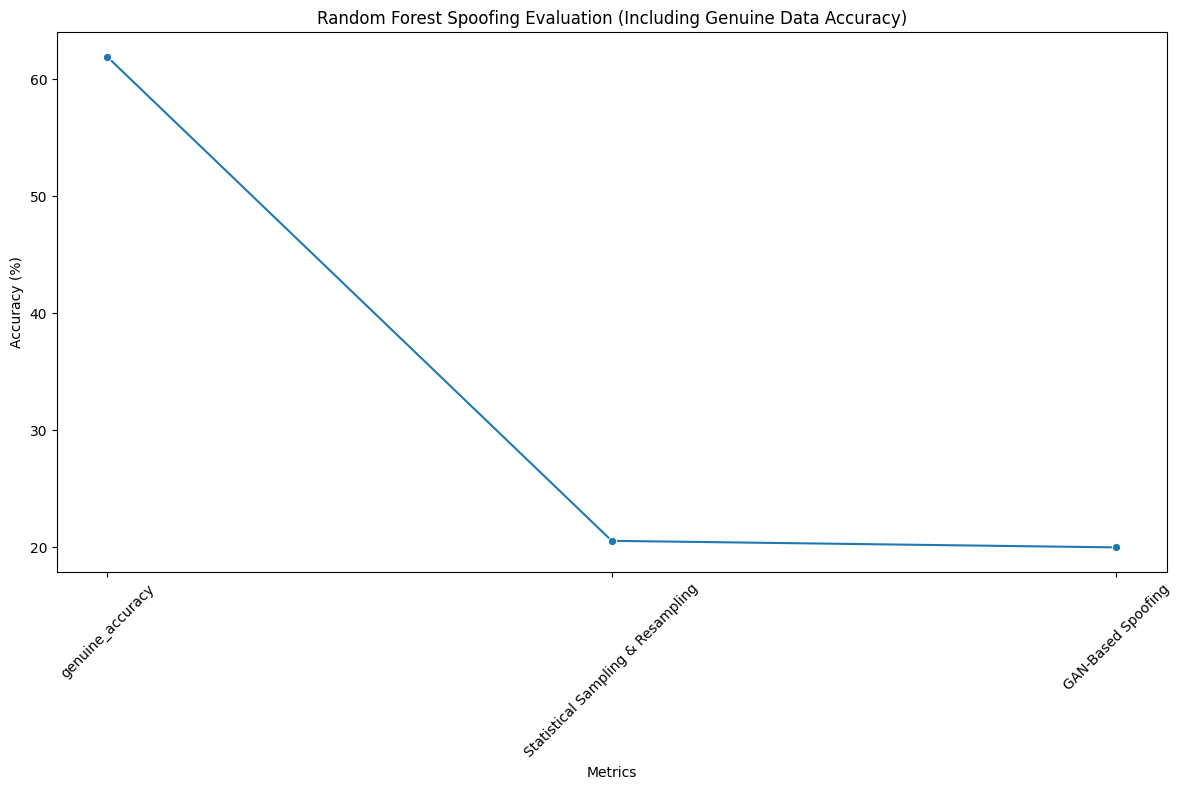

<ipython-input-7-a73df4319079>:174: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=melted_data, x='Metric', y='Accuracy', marker='o', palette='Set2')


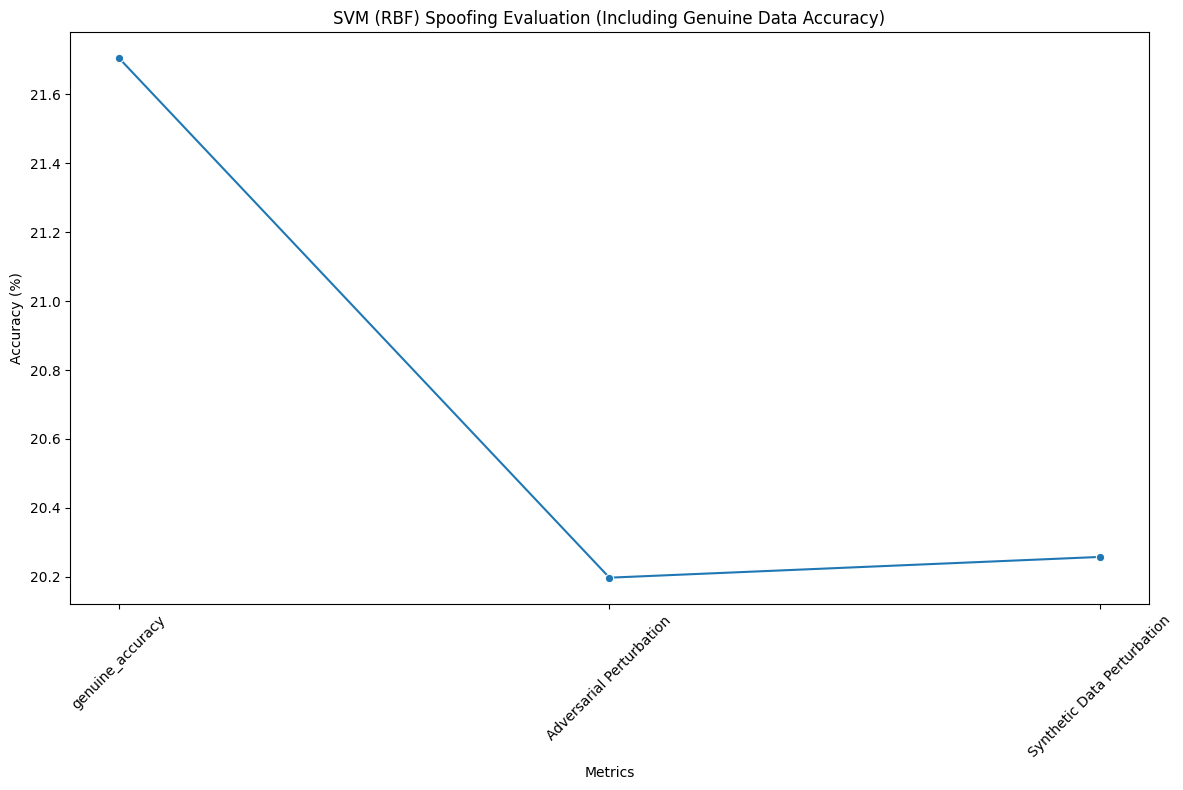

<ipython-input-7-a73df4319079>:174: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=melted_data, x='Metric', y='Accuracy', marker='o', palette='Set2')


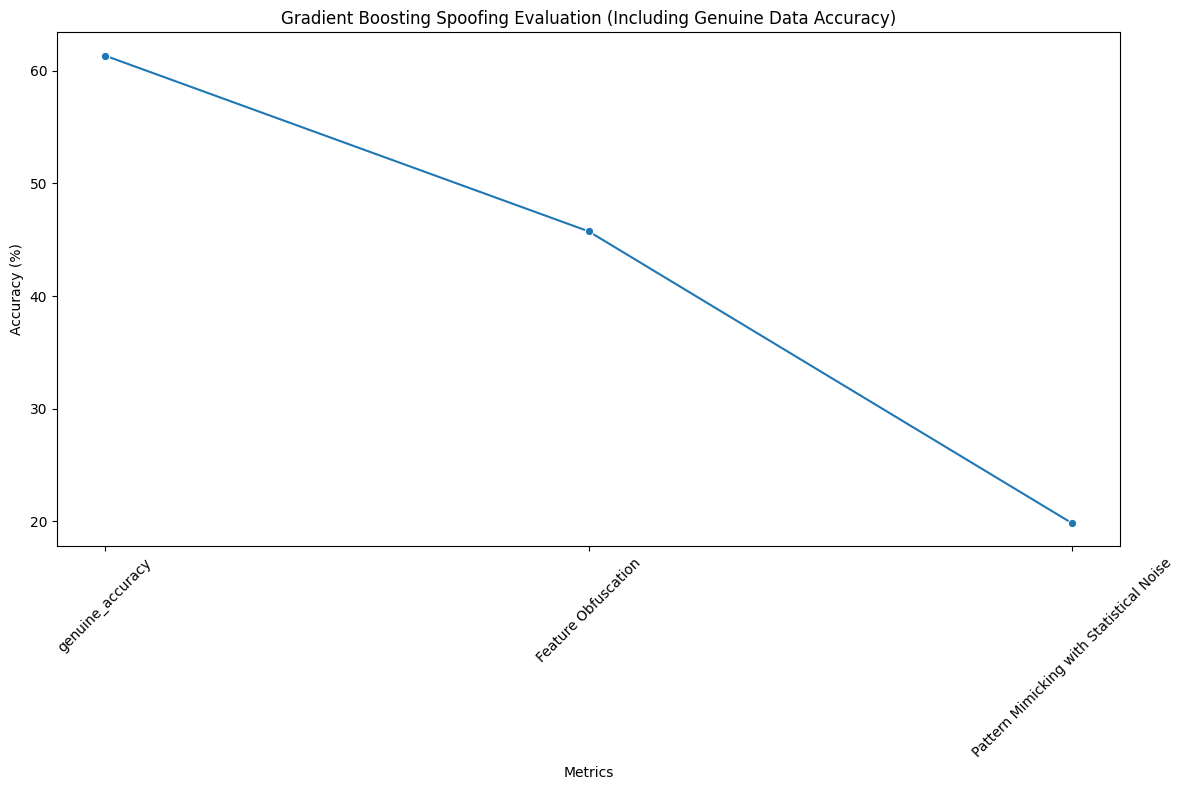

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Data Augmentation Techniques (Spoofing)
# ---------------------------
def generate_gan_data(data, n_samples):
    """
    Simulate GAN-based spoofing by creating synthetic data.
    """
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    return np.random.normal(mean, std_dev, (n_samples, data.shape[1]))

def adversarial_perturbation(data, epsilon=0.1):
    """
    Simulate adversarial perturbations by adding small noise to mimic realistic attacks.
    """
    return data + epsilon * np.sign(np.random.randn(*data.shape))

def feature_obfuscation(data, mask_fraction=0.3):
    """
    Obfuscate a fraction of features to simulate pattern-mimicking spoofing.
    """
    masked_data = data.copy()
    n_features_to_mask = int(data.shape[1] * mask_fraction)
    mask_indices = np.random.choice(data.shape[1], n_features_to_mask, replace=False)
    masked_data[:, mask_indices] = 0
    return masked_data

# ---------------------------
# Machine Learning Classifiers
# ---------------------------
def train_random_forest(X_train, y_train):
    model = RandomForestClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model

def train_svm_rbf(X_train, y_train):
    model = SVC(kernel="rbf", C=1.0, gamma='scale', probability=True, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_gradient_boosting(X_train, y_train):
    model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    return model

# ---------------------------
# Evaluation Workflow with Cross-Validation
# ---------------------------
def evaluate_model_with_folds(X, y, spoofing_methods, model_fn, method_name, n_folds=3):
    """
    Train and evaluate a classifier with n-fold cross-validation against genuine and spoofed data.
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train the model
        model = model_fn(X_train, y_train)
        genuine_accuracy = accuracy_score(y_test, model.predict(X_test)) * 100

        # Evaluate spoofing techniques
        spoofing_results = {}
        for spoofing_name, spoofing_fn in spoofing_methods.items():
            spoofed_data = spoofing_fn(X_test)
            spoofed_accuracy = accuracy_score(y_test, model.predict(spoofed_data)) * 100
            spoofing_results[spoofing_name] = spoofed_accuracy

        # Combine results into a single dictionary
        results = {
            "authentication_method": method_name,
            "genuine_accuracy": genuine_accuracy,
        }
        results.update(spoofing_results)
        fold_results.append(results)

    # Convert to DataFrame and calculate averages
    fold_results_df = pd.DataFrame(fold_results)
    numeric_columns = fold_results_df.select_dtypes(include=[np.number])  # Select only numeric columns
    averaged_results = numeric_columns.mean().to_dict()  # Compute mean for numeric columns
    averaged_results["authentication_method"] = method_name  # Add method name back to results
    return averaged_results


# ---------------------------
# Dataset Preparation
# ---------------------------
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Security_project/free-text.csv')

# Clean and prepare data
data.columns = data.columns.str.strip()
keystroke_features = ["DU.key1.key1", "DD.key1.key2", "DU.key1.key2", "UD.key1.key2", "UU.key1.key2"]
selected_users = ['p049', 'p005', 'p073', 'p045', 'p012']
filtered_data = data[data['participant'].isin(selected_users)]

# Convert features to numeric
for feature in keystroke_features:
    filtered_data[feature] = pd.to_numeric(filtered_data[feature], errors='coerce')
filtered_data = filtered_data.dropna(subset=keystroke_features)

# Define feature matrix and target labels
X = filtered_data[keystroke_features].values
y = filtered_data['participant'].values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# ---------------------------
# Spoofing Techniques
# ---------------------------
spoofing_methods_rf = {
    "Statistical Sampling & Resampling": lambda data: generate_gan_data(data, len(data)),
    "GAN-Based Spoofing": lambda data: generate_gan_data(data, len(data))
}

spoofing_methods_svm = {
    "Adversarial Perturbation": lambda data: adversarial_perturbation(data, epsilon=0.1),
    "Synthetic Data Perturbation": lambda data: generate_gan_data(data, len(data))
}

spoofing_methods_gb = {
    "Feature Obfuscation": lambda data: feature_obfuscation(data, mask_fraction=0.3),
    "Pattern Mimicking with Statistical Noise": lambda data: adversarial_perturbation(data, epsilon=0.2)
}

# ---------------------------
# Run Evaluations with Cross-Validation
# ---------------------------
results = []

# Evaluate models with spoofing techniques and cross-validation
results.append(evaluate_model_with_folds(X, y, spoofing_methods_rf, train_random_forest, "Random Forest", n_folds=3))
results.append(evaluate_model_with_folds(X, y, spoofing_methods_svm, train_svm_rbf, "SVM (RBF)", n_folds=3))
results.append(evaluate_model_with_folds(X, y, spoofing_methods_gb, train_gradient_boosting, "Gradient Boosting", n_folds=3))

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# ---------------------------
# Visualization Function (Line Plot)
# ---------------------------
def visualize_results_with_genuine(results_df, method, spoofing_techniques):
    """
    Generate line plots for each authentication method and spoofing techniques, including genuine accuracy.
    """
    filtered_data = results_df[results_df['authentication_method'] == method]
    if filtered_data.empty:
        print(f"Warning: No data found for method '{method}'. Skipping visualization.")
        return

    # Melt the DataFrame for easier plotting
    melted_data = filtered_data.melt(
        id_vars=['authentication_method'], var_name='Metric', value_name='Accuracy'
    )

    # Filter for the selected spoofing techniques and genuine accuracy
    spoofing_techniques_with_genuine = ['genuine_accuracy'] + spoofing_techniques
    melted_data = melted_data[melted_data['Metric'].isin(spoofing_techniques_with_genuine)]

    # Plot the data
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=melted_data, x='Metric', y='Accuracy', marker='o', palette='Set2')
    plt.title(f"{method} Spoofing Evaluation (Including Genuine Data Accuracy)")
    plt.xlabel("Metrics")
    plt.ylabel("Accuracy (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ---------------------------
# Visualizations
# ---------------------------
# Spoofing techniques for each classifier, including genuine accuracy
spoofing_methods_rf = ["Statistical Sampling & Resampling", "GAN-Based Spoofing"]
spoofing_methods_svm = ["Adversarial Perturbation", "Synthetic Data Perturbation"]
spoofing_methods_gb = ["Feature Obfuscation", "Pattern Mimicking with Statistical Noise"]

# Visualize results
visualize_results_with_genuine(results_df, "Random Forest", spoofing_methods_rf)
visualize_results_with_genuine(results_df, "SVM (RBF)", spoofing_methods_svm)
visualize_results_with_genuine(results_df, "Gradient Boosting", spoofing_methods_gb)



Average EER Results Across All Methods:
              Method                        Spoofing Technique       EER  \
0      RANDOM FOREST         Statistical Sampling & Resampling  0.548726   
1      RANDOM FOREST                        GAN-Based Spoofing  0.550892   
2          SVM (RBF)                  Adversarial Perturbation  0.493276   
3          SVM (RBF)               Synthetic Data Perturbation  0.197975   
4  GRADIENT BOOSTING                       Feature Obfuscation  0.446042   
5  GRADIENT BOOSTING  Pattern Mimicking with Statistical Noise  0.453261   

   Threshold  
0      292.2  
1      292.2  
2     3114.6  
3     1934.8  
4     3039.6  
5     2640.8  


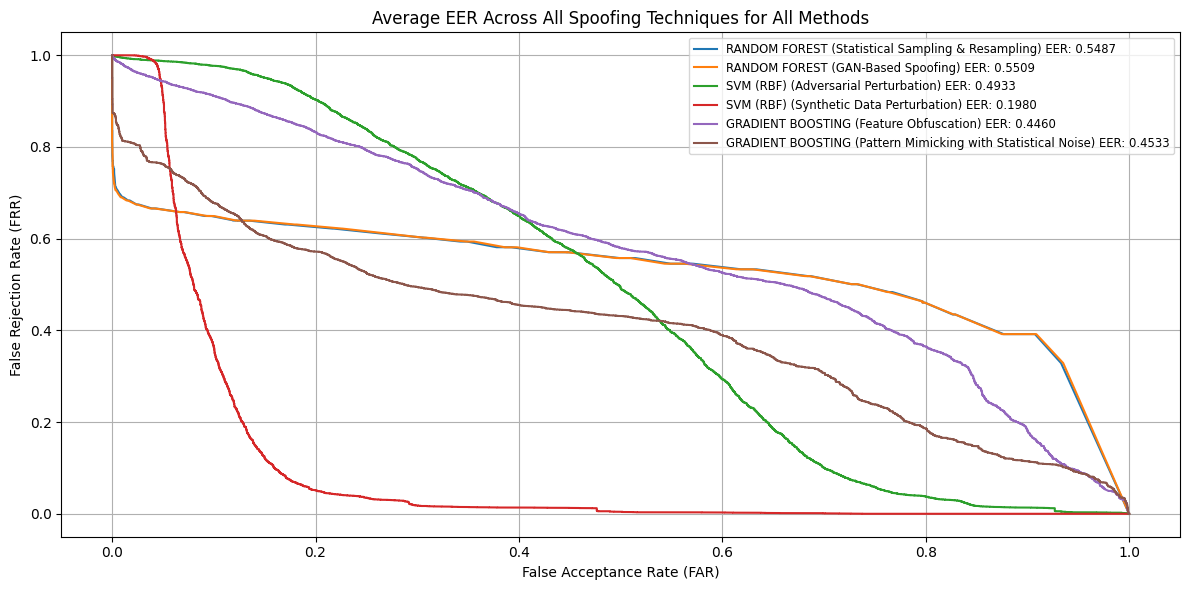

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Define Helper Functions
# ---------------------------
def calculate_eer(fpr, tpr):
    """Calculate Equal Error Rate (EER) given FPR and TPR."""
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fpr - fnr))  # Find the index of EER
    eer = fpr[eer_index]
    threshold = eer_index
    return eer, threshold

def calculate_average_eer_per_fold(genuine_scores, spoof_scores):
    """
    Calculate EER for a specific fold given genuine and spoof scores.
    """
    distances = np.concatenate([genuine_scores, spoof_scores])
    labels = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(spoof_scores)])

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(labels, distances, pos_label=1)

    # Compute EER
    eer, threshold = calculate_eer(fpr, tpr)
    return eer, threshold, fpr, 1 - tpr

def evaluate_average_eer_with_folds(X, y, spoofing_methods, model_fn, method_name, n_folds=5):
    """
    Evaluate average EER with n-fold cross-validation for all spoofing techniques.
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train the model
        model = model_fn(X_train, y_train)

        # Evaluate EER for each spoofing technique
        for spoofing_name, spoofing_fn in spoofing_methods.items():
            # Genuine and spoofed predictions
            genuine_scores = model.predict_proba(X_test)[:, 1]  # Use probabilities for EER calculation
            spoofed_data = spoofing_fn(X_test)
            spoof_scores = model.predict_proba(spoofed_data)[:, 1]

            # Calculate EER for this fold
            eer, threshold, fpr, fnr = calculate_average_eer_per_fold(genuine_scores, spoof_scores)
            fold_results.append({
                "Method": method_name.upper(),
                "Spoofing Technique": spoofing_name,
                "EER": eer,
                "Threshold": threshold,
                "FPR": fpr,  # Store FPR curve
                "FNR": fnr   # Store FNR curve
            })

    # Aggregate results across all folds
    aggregated_results = []
    results_df = pd.DataFrame(fold_results)
    for spoofing_name in spoofing_methods.keys():
        spoofing_results = results_df[results_df["Spoofing Technique"] == spoofing_name]
        averaged_result = spoofing_results.mean(numeric_only=True).to_dict()
        averaged_result["Method"] = method_name.upper()
        averaged_result["Spoofing Technique"] = spoofing_name
        # Preserve FPR and FNR as lists (averaging makes no sense here)
        averaged_result["FPR"] = spoofing_results.iloc[0]["FPR"]  # Use the first FPR
        averaged_result["FNR"] = spoofing_results.iloc[0]["FNR"]  # Use the first FNR
        aggregated_results.append(averaged_result)

    return aggregated_results


# ---------------------------
# Dataset Preparation
# ---------------------------
# Example dataset: Replace with actual dataset
# Use filtered data from the earlier steps
X = filtered_data[keystroke_features].values
y = filtered_data['participant'].values

# ---------------------------
# Spoofing Techniques
# ---------------------------
spoofing_methods_rf = {
    "Statistical Sampling & Resampling": lambda data: generate_gan_data(data, len(data)),
    "GAN-Based Spoofing": lambda data: generate_gan_data(data, len(data))
}

spoofing_methods_svm = {
    "Adversarial Perturbation": lambda data: adversarial_perturbation(data, epsilon=0.1),
    "Synthetic Data Perturbation": lambda data: generate_gan_data(data, len(data))
}

spoofing_methods_gb = {
    "Feature Obfuscation": lambda data: feature_obfuscation(data, mask_fraction=0.3),
    "Pattern Mimicking with Statistical Noise": lambda data: adversarial_perturbation(data, epsilon=0.2)
}

# ---------------------------
# Evaluate EER for Each Method
# ---------------------------
results = []
results.extend(evaluate_average_eer_with_folds(X, y, spoofing_methods_rf, train_random_forest, "Random Forest", n_folds=5))
results.extend(evaluate_average_eer_with_folds(X, y, spoofing_methods_svm, train_svm_rbf, "SVM (RBF)", n_folds=5))
results.extend(evaluate_average_eer_with_folds(X, y, spoofing_methods_gb, train_gradient_boosting, "Gradient Boosting", n_folds=5))

# Convert results to a DataFrame
eer_results_df = pd.DataFrame(results)

# ---------------------------
# Prepare Results for Display
# ---------------------------
eer_results_table = eer_results_df[["Method", "Spoofing Technique", "EER", "Threshold"]]
print("Average EER Results Across All Methods:")
print(eer_results_table)

# ---------------------------
# Visualization for Average EER
# ---------------------------
plt.figure(figsize=(12, 6))
for _, row in eer_results_df.iterrows():
    plt.plot(row["FPR"], row["FNR"], label=f"{row['Method']} ({row['Spoofing Technique']}) EER: {row['EER']:.4f}")

plt.title("Average EER Across All Spoofing Techniques for All Methods")
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("False Rejection Rate (FRR)")
plt.legend(loc='upper right', fontsize='small')
plt.grid()
plt.tight_layout()
plt.show()


# Deep Learning approaches

## LSTM vs CNN

<ipython-input-15-62563625b686>:16: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Security_project/free-text.csv')
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.2533 - loss: 1.7969
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3024 - loss: 1.5489
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.4051 - loss: 1.4385
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4129 - loss: 1.3996
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4221 - loss: 1.3947
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4287 - loss: 1.3748
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.4405 - loss: 1.3667
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4325 - loss: 1.3771
Epoch 9/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4326 - loss: 1.3658
Epoch 10/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4401 - loss: 1.3537
Epoch 11/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4384 - loss: 1.3495
Epoch 12/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3009 - loss: 2.5269
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4039 - loss: 1.5595
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4205 - loss: 1.4163
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4212 - loss: 1.3935
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4261 - loss: 1.3963
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4246 - loss: 1.3838
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4377 - loss: 1.3811
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4353 - loss: 1.3843
Epoch 9/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4330 - loss: 1.3726
Epoch 10/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4344 - loss: 1.3776
Epoch 11/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4342 - loss: 1.3730
Epoch 12/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2585 - loss: 1.7925
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2860 - loss: 1.5579
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.3669 - loss: 1.5075
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4192 - loss: 1.4086
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4231 - loss: 1.3955
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.4300 - loss: 1.3852
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4365 - loss: 1.3785
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4432 - loss: 1.3630
Epoch 9/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4444 - loss: 1.3572
Epoch 10/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4437 - loss: 1.3547
Epoch 11/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4364 - loss: 1.3607
Epoch 12/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2540 - loss: 1.7882
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2909 - loss: 1.5540
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3376 - loss: 1.5342
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4173 - loss: 1.4147
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4220 - loss: 1.3967
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4236 - loss: 1.3935
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4330 - loss: 1.3741
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.4359 - loss: 1.3677
Epoch 9/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4406 - loss: 1.3622
Epoch 10/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4393 - loss: 1.3566
Epoch 11/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4392 - loss: 1.3578
Epoch 12/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - ac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3043 - loss: 2.5392
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4099 - loss: 1.5455
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4250 - loss: 1.4176
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4214 - loss: 1.3977
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4291 - loss: 1.3841
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4341 - loss: 1.3811
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4334 - loss: 1.3783
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4345 - loss: 1.3749
Epoch 9/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4356 - loss: 1.3734
Epoch 10/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4393 - loss: 1.3731
Epoch 11/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4379 - loss: 1.3711
Epoch 12/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3091 - loss: 2.5395
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4002 - loss: 1.5505
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4167 - loss: 1.4285
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4238 - loss: 1.4009
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4283 - loss: 1.3881
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4278 - loss: 1.3877
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4307 - loss: 1.3797
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4398 - loss: 1.3714
Epoch 9/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4355 - loss: 1.3732
Epoch 10/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4458 - loss: 1.3608
Epoch 11/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4325 - loss: 1.3724
Epoch 12/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


693/693 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3035 - loss: 2.5273
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3987 - loss: 1.5525
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4192 - loss: 1.4207
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4217 - loss: 1.4033
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4251 - loss: 1.3916
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4306 - loss: 1.3870
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4366 - loss: 1.3782
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4366 - loss: 1.3757
Epoch 9/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4313 - loss: 1.3807
Epoch 10/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4332 - loss: 1.3774
Epoch 11/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4363 - loss: 1.3578
Epoch 12/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

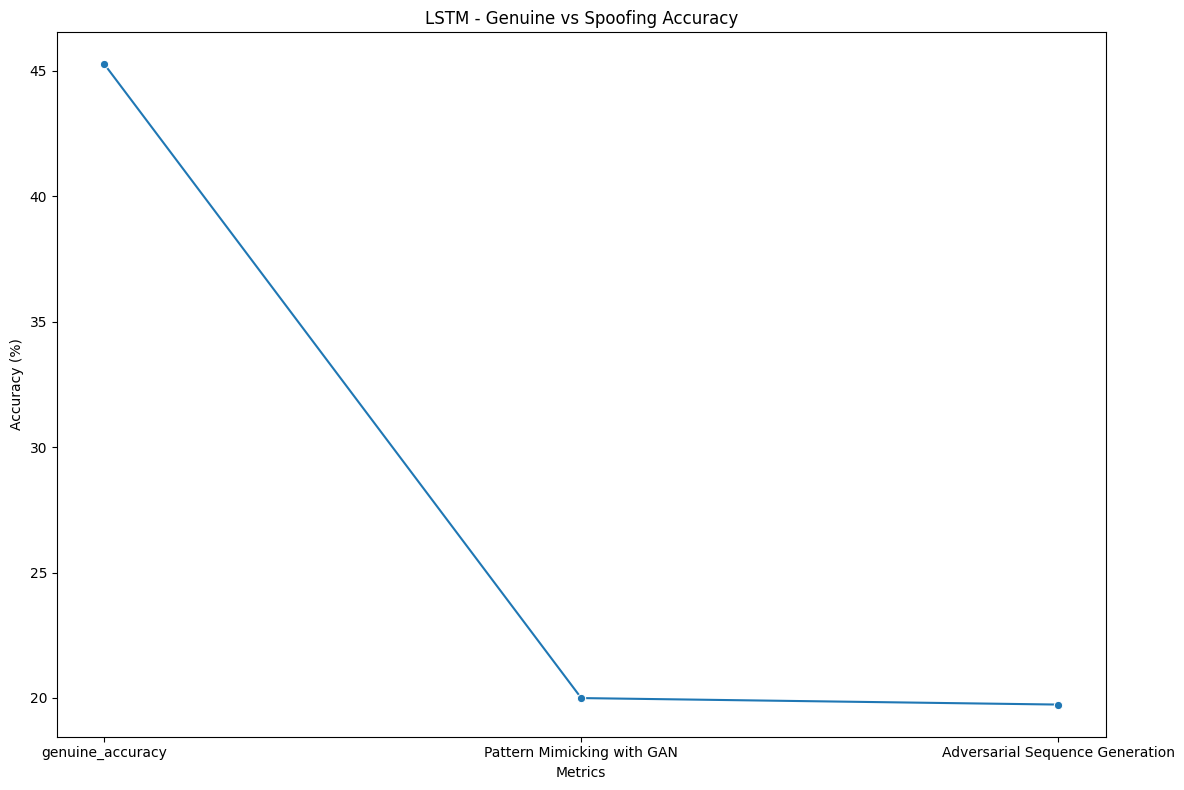

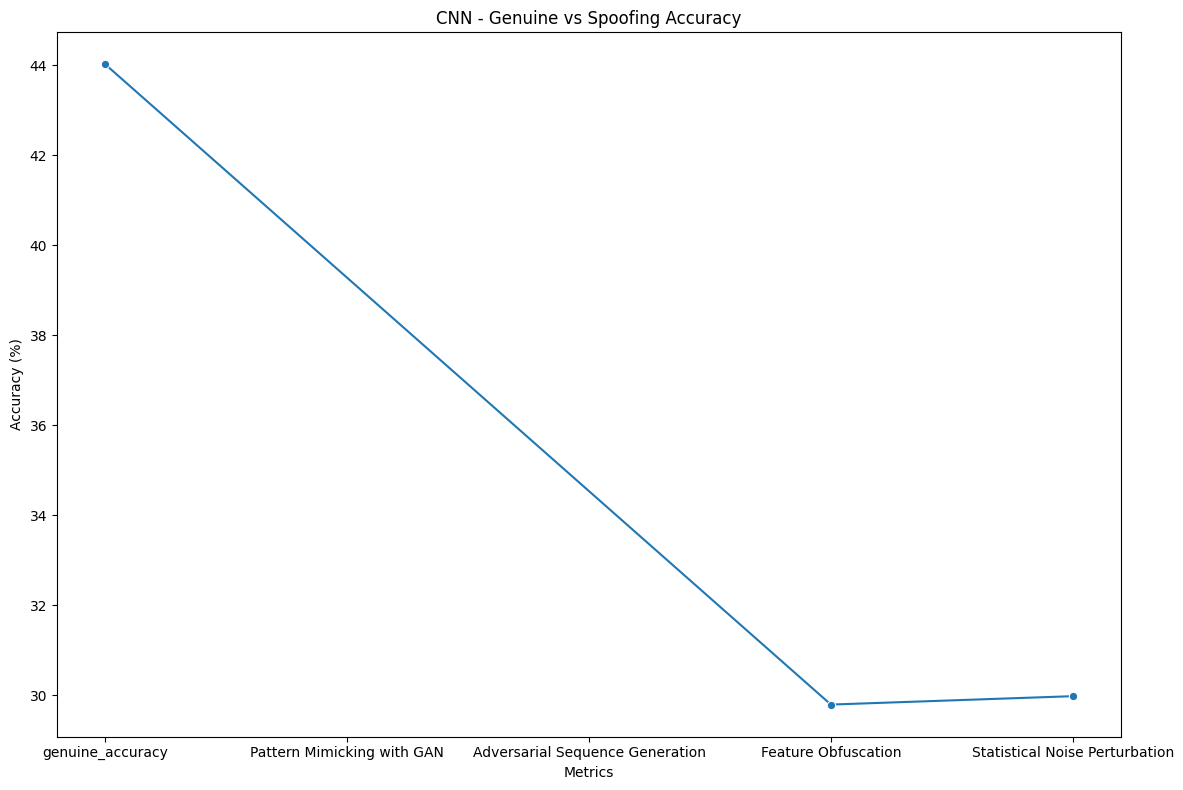

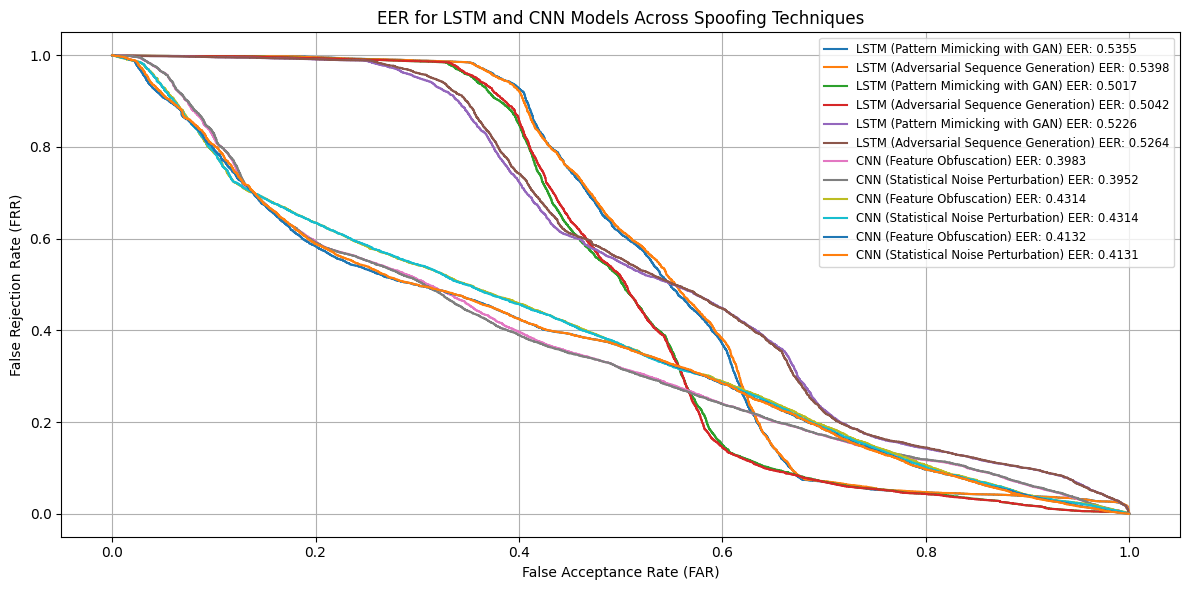

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Dropout, BatchNormalization, Bidirectional, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Data Preparation
# ---------------------------
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Security_project/free-text.csv')

# Clean and prepare data
data.columns = data.columns.str.strip()
keystroke_features = ["DU.key1.key1", "DD.key1.key2", "DU.key1.key2", "UD.key1.key2", "UU.key1.key2"]
selected_users = ['p049', 'p005', 'p073', 'p045', 'p012']
filtered_data = data[data['participant'].isin(selected_users)]

# Convert features to numeric
for feature in keystroke_features:
    filtered_data[feature] = pd.to_numeric(filtered_data[feature], errors='coerce')
filtered_data = filtered_data.dropna(subset=keystroke_features)

# Define feature matrix and target labels
X = filtered_data[keystroke_features].values
y = filtered_data['participant'].values

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Reshape data for LSTM and CNN (3D input: samples, timesteps, features)
X_lstm = X.reshape((X.shape[0], 1, X.shape[1]))
X_cnn = X.reshape((X.shape[0], 1, X.shape[1]))

# ---------------------------
# Spoofing Techniques
# ---------------------------
def generate_gan_pattern(data, n_samples):
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    spoofed_data = np.random.normal(loc=mean, scale=std_dev, size=(n_samples, data.shape[-1]))
    return spoofed_data.reshape((n_samples, 1, data.shape[-1]))

def feature_obfuscation(data, mask_fraction=0.3):
    masked_data = data.copy()
    n_features_to_mask = int(data.shape[2] * mask_fraction)
    for i in range(data.shape[0]):
        mask_indices = np.random.choice(data.shape[2], n_features_to_mask, replace=False)
        masked_data[i, 0, mask_indices] = 0
    return masked_data

# ---------------------------
# Improved Model Architectures
# ---------------------------
def build_bidirectional_lstm(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dense(128, activation='relu', kernel_regularizer='l2'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_improved_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=1, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(128, kernel_size=1, activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer='l2'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# Cross-Validation and Accuracy Evaluation
# ---------------------------
def cross_validate_model(X, y, build_model_fn, spoofing_methods, input_shape, n_folds=3):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    results = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = build_model_fn(input_shape, len(np.unique(y)))
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

        genuine_accuracy = model.evaluate(X_test, y_test, verbose=0)[1] * 100

        spoofing_results = {}
        for spoofing_name, spoofing_fn in spoofing_methods.items():
            spoofed_data = spoofing_fn(X_test)
            spoofed_accuracy = model.evaluate(spoofed_data, y_test, verbose=0)[1] * 100
            spoofing_results[spoofing_name] = spoofed_accuracy

        results.append({"genuine_accuracy": genuine_accuracy, **spoofing_results})

    results_df = pd.DataFrame(results)
    averaged_results = results_df.mean().to_dict()
    return averaged_results

# ---------------------------
# EER Calculation
# ---------------------------
def calculate_eer(fpr, tpr):
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = fpr[eer_index]
    return eer, eer_index

def calculate_average_eer_per_fold(genuine_scores, spoof_scores):
    distances = np.concatenate([genuine_scores, spoof_scores])
    labels = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(spoof_scores)])
    fpr, tpr, thresholds = roc_curve(labels, distances, pos_label=1)
    eer, eer_index = calculate_eer(fpr, tpr)
    return eer, thresholds[eer_index], fpr, 1 - tpr

def evaluate_model_eer_with_folds(X, y, spoofing_methods, model_fn, method_name, input_shape, n_folds=3):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    eer_results = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = model_fn(input_shape, len(np.unique(y)))
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

        for spoofing_name, spoofing_fn in spoofing_methods.items():
            genuine_preds = model.predict(X_test)
            genuine_scores = np.max(genuine_preds, axis=1)

            spoofed_data = spoofing_fn(X_test)
            spoofed_preds = model.predict(spoofed_data)
            spoofed_scores = np.max(spoofed_preds, axis=1)

            eer, threshold, fpr, fnr = calculate_average_eer_per_fold(genuine_scores, spoofed_scores)
            eer_results.append({
                "Method": method_name,
                "Spoofing Technique": spoofing_name,
                "EER": eer,
                "Threshold": threshold,
                "FPR": fpr,
                "FNR": fnr
            })

    return eer_results

# ---------------------------
# Run Evaluations (Accuracy and EER)
# ---------------------------
lstm_spoofing_methods = {
    "Pattern Mimicking with GAN": lambda data: generate_gan_pattern(data, len(data)),
    "Adversarial Sequence Generation": lambda data: generate_gan_pattern(data, len(data))
}

cnn_spoofing_methods = {
    "Feature Obfuscation": lambda data: feature_obfuscation(data),
    "Statistical Noise Perturbation": lambda data: feature_obfuscation(data, mask_fraction=0.2)
}

# Accuracy Evaluation
lstm_results = cross_validate_model(X_lstm, y_encoded, build_bidirectional_lstm, lstm_spoofing_methods, input_shape=(1, X.shape[1]), n_folds=3)
cnn_results = cross_validate_model(X_cnn, y_encoded, build_improved_cnn, cnn_spoofing_methods, input_shape=(1, X.shape[1]), n_folds=3)

results_df = pd.DataFrame([
    {"authentication_method": "LSTM", **lstm_results},
    {"authentication_method": "CNN", **cnn_results}
])

# EER Evaluation
lstm_eer_results = evaluate_model_eer_with_folds(X_lstm, y_encoded, lstm_spoofing_methods, build_bidirectional_lstm, "LSTM", input_shape=(1, X.shape[1]))
cnn_eer_results = evaluate_model_eer_with_folds(X_cnn, y_encoded, cnn_spoofing_methods, build_improved_cnn, "CNN", input_shape=(1, X.shape[1]))

# Calculate Average EER and Threshold
lstm_eer = np.mean([result["EER"] for result in lstm_eer_results])
lstm_threshold = np.mean([result["Threshold"] for result in lstm_eer_results])
cnn_eer = np.mean([result["EER"] for result in cnn_eer_results])
cnn_threshold = np.mean([result["Threshold"] for result in cnn_eer_results])

# Print Results
print(f"LSTM EER: {lstm_eer:.4f}, Threshold: {lstm_threshold:.4f}")
print(f"CNN EER: {cnn_eer:.4f}, Threshold: {cnn_threshold:.4f}")

# ---------------------------
# Visualizations
# ---------------------------
# Accuracy Visualization
def visualize_results_lineplot(results_df, method, spoofing_techniques):
    lineplot_data = results_df[results_df['authentication_method'] == method]
    lineplot_data = lineplot_data.melt(id_vars=['authentication_method'], var_name='Metric', value_name='Accuracy')

    plt.figure(figsize=(12, 8))
    sns.lineplot(data=lineplot_data, x='Metric', y='Accuracy', marker='o', sort=False)
    plt.title(f"{method} - Genuine vs Spoofing Accuracy")
    plt.xlabel("Metrics")
    plt.ylabel("Accuracy (%)")
    plt.tight_layout()
    plt.show()

visualize_results_lineplot(results_df, "LSTM", list(lstm_spoofing_methods.keys()))
visualize_results_lineplot(results_df, "CNN", list(cnn_spoofing_methods.keys()))

# EER Visualization
plt.figure(figsize=(12, 6))
for result in lstm_eer_results + cnn_eer_results:
    plt.plot(result["FPR"], result["FNR"], label=f"{result['Method']} ({result['Spoofing Technique']}) EER: {result['EER']:.4f}")

plt.title("EER for LSTM and CNN Models Across Spoofing Techniques")
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("False Rejection Rate (FRR)")
plt.legend(loc='upper right', fontsize='small')
plt.grid()
plt.tight_layout()
plt.show()


## GAN

### GAN - Basic

GAN Training Data Shape: (33237, 5)


Before conversion at epoch 0:
d_loss: 0.6949867606163025, type: <class 'numpy.ndarray'>
d_acc: 0.3125, type: <class 'numpy.ndarray'>
g_loss: [array(0.69498676, dtype=float32), array(0.69498676, dtype=float32), array(0.3125, dtype=float32)], type: <class 'list'>
Epoch 0/500 | D Loss: 0.6950 | D Acc: 0.3125 | G Loss: 0.6950
After conversion at epoch 0:
d_loss: 0.6949867606163025, type: <class 'float'>
d_acc: 0.3125, type: <class 'float'>
g_loss: 0.6949867606163025, type: <class 'float'>

Before conversion at epoch 100:
d_loss: 0.6191363334655762, type: <class 'numpy.ndarray'>
d_acc: 0.6618192791938782, type: <class 'numpy.ndarray'>
g_loss: [array(0.61913633, dtype=float32), array(0.61913633, dtype=float32), array(0.6618193, dtype=float32)], type: <class 'list'>
Epoch 100/500 | D Loss: 0.6191 | D Acc: 0.6618 | G Loss: 0.6191
After conversion at epoch 100:
d_loss: 0.6191363334655762, type: <class 'float'>
d_acc: 0.6618192791938782, type: <class 'float'>
g_loss: 0.6191363334655762, type: <c

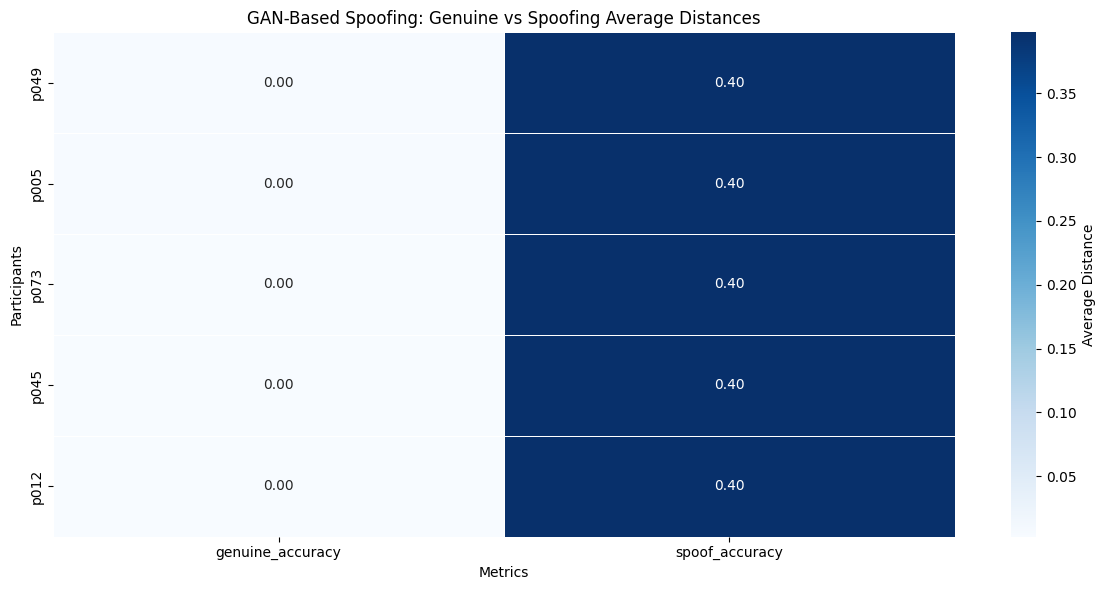

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Data Loading and Preprocessing
# ---------------------------

# Load the dataset with low_memory=False to suppress DtypeWarning
data = pd.read_csv('drive/MyDrive/Security_project/free-text.csv', low_memory=False)

# Strip extra spaces from column names
data.columns = data.columns.str.strip()

# Update keystroke features based on the corrected column names
keystroke_features = [
    "DU.key1.key1",
    "DD.key1.key2",
    "DU.key1.key2",
    "UD.key1.key2",
    "UU.key1.key2"
]

# Filter for selected participants
selected_users = ['p049', 'p005', 'p073', 'p045', 'p012']
filtered_data = data[data['participant'].isin(selected_users)].copy()

# Convert keystroke features to numeric, coercing errors
for feature in keystroke_features:
    filtered_data[feature] = pd.to_numeric(filtered_data[feature], errors='coerce')

# Drop rows with NaN values after conversion
filtered_data = filtered_data.dropna(subset=keystroke_features)

# Select keystroke features and convert to NumPy array
gan_training_data = filtered_data[keystroke_features].values

# Ensure data is in float format and normalize
gan_training_data = gan_training_data.astype('float32')
scaler = MinMaxScaler()
gan_training_data = scaler.fit_transform(gan_training_data)

# Verify Data Shape
print("GAN Training Data Shape:", gan_training_data.shape)

# ---------------------------
# GAN Components
# ---------------------------

def build_generator(input_dim, output_dim):
    generator = Sequential([
        Input(shape=(input_dim,)),
        Dense(64),
        LeakyReLU(negative_slope=0.2),
        Dense(128),
        LeakyReLU(negative_slope=0.2),
        Dense(output_dim, activation='tanh')
    ])
    return generator

def build_discriminator(input_dim):
    discriminator = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        LeakyReLU(negative_slope=0.2),
        Dense(64),
        LeakyReLU(negative_slope=0.2),
        Dense(1, activation='sigmoid')
    ])
    return discriminator

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(generator.input_shape[1],))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    return gan

# ---------------------------
# Train GAN
# ---------------------------

def train_gan(generator, discriminator, gan_training_data, epochs=1000, batch_size=32):
    """
    Train the GAN with the given generator and discriminator.
    """
    # Compile the Discriminator
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Combine Generator and Discriminator into GAN
    gan = build_gan(generator, discriminator)

    # Training Loop
    for epoch in range(epochs):
        # Generate noise and create synthetic data
        noise = np.random.normal(0, 1, (batch_size, gan_training_data.shape[1]))
        generated_data = generator.predict(noise, verbose=0)

        # Get a random batch of real data
        idx = np.random.randint(0, gan_training_data.shape[0], batch_size)
        real_data = gan_training_data[idx]

        # Combine real and synthetic data
        combined_data = np.concatenate([real_data, generated_data])

        # Create labels for discriminator
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        labels = np.concatenate([real_labels, fake_labels])

        # Train the Discriminator
        discriminator.trainable = True
        metrics = discriminator.train_on_batch(combined_data, labels)
        d_loss = metrics[0]
        d_acc = metrics[1]

        # Train the Generator (via GAN) to fool the Discriminator
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, gan_training_data.shape[1]))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # Labels as 1 to fool the discriminator

        # Debug statements before conversion
        if epoch % 100 == 0:
            print(f"Before conversion at epoch {epoch}:")
            print(f"d_loss: {d_loss}, type: {type(d_loss)}")
            print(f"d_acc: {d_acc}, type: {type(d_acc)}")
            print(f"g_loss: {g_loss}, type: {type(g_loss)}")

        # Convert outputs to scalar floats
        if isinstance(d_loss, (tf.Tensor, np.ndarray, list)):
            d_loss = float(np.array(d_loss).flatten()[0])
        if isinstance(d_acc, (tf.Tensor, np.ndarray, list)):
            d_acc = float(np.array(d_acc).flatten()[0])
        if isinstance(g_loss, (tf.Tensor, np.ndarray, list)):
            g_loss = float(np.array(g_loss).flatten()[0])

        # Log progress with debug statements
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss:.4f} | D Acc: {d_acc:.4f} | G Loss: {g_loss:.4f}")
            print(f"After conversion at epoch {epoch}:")
            print(f"d_loss: {d_loss}, type: {type(d_loss)}")
            print(f"d_acc: {d_acc}, type: {type(d_acc)}")
            print(f"g_loss: {g_loss}, type: {type(g_loss)}\n")

    return generator

# Initialize GAN components
input_dim = gan_training_data.shape[1]
generator = build_generator(input_dim=input_dim, output_dim=input_dim)
discriminator = build_discriminator(input_dim=input_dim)

# Train the GAN
trained_generator = train_gan(generator, discriminator, gan_training_data, epochs=500, batch_size=32)

# ---------------------------
# Evaluate Spoofing
# ---------------------------

def evaluate_spoofing(data, keystroke_features, selected_users, generator):
    results = []
    for user in selected_users:
        user_data = data[data['participant'] == user][keystroke_features].values

        # Ensure data is in float format and normalize using the same scaler
        user_data = user_data.astype('float32')
        user_data = scaler.transform(user_data)

        # Split data into genuine and spoofed sets
        genuine_data = user_data[:len(user_data) // 2]
        spoofed_data = generator.predict(np.random.normal(0, 1, (len(genuine_data), generator.input_shape[1])))

        # Calculate distances for genuine and spoofed data
        genuine_distances = np.linalg.norm(genuine_data - genuine_data.mean(axis=0), axis=1)
        spoofed_distances = np.linalg.norm(spoofed_data - genuine_data.mean(axis=0), axis=1)

        # Calculate average distances
        genuine_accuracy = np.mean(genuine_distances)
        spoof_accuracy = np.mean(spoofed_distances)

        # Debug statements
        print(f"User: {user}")
        print(f"  Genuine Average Distance: {genuine_accuracy}")
        print(f"  Spoofed Average Distance: {spoof_accuracy}\n")

        results.append({
            'participant': user,
            'genuine_accuracy': genuine_accuracy,
            'spoof_accuracy': spoof_accuracy
        })
    return pd.DataFrame(results)

results_df = evaluate_spoofing(filtered_data, keystroke_features, selected_users, trained_generator)

# ---------------------------
# Visualization
# ---------------------------

plt.figure(figsize=(12, 6))
sns.heatmap(results_df.set_index('participant'), annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, cbar_kws={"label": "Average Distance"})
plt.title("GAN-Based Spoofing: Genuine vs Spoofing Average Distances")
plt.xlabel("Metrics")
plt.ylabel("Participants")
plt.tight_layout()
plt.show()


### GAN - Phase I

GAN Training Data Shape: (33237, 5)
Epoch 0/1000 | D Loss: 0.6729 | D Acc: 0.5000 | G Loss: 0.6729
Epoch 100/1000 | D Loss: 0.6598 | D Acc: 0.5304 | G Loss: 0.6598
Epoch 200/1000 | D Loss: 0.6852 | D Acc: 0.5211 | G Loss: 0.6852
Epoch 300/1000 | D Loss: 0.6806 | D Acc: 0.5880 | G Loss: 0.6806
Epoch 400/1000 | D Loss: 0.6815 | D Acc: 0.5654 | G Loss: 0.6815
Epoch 500/1000 | D Loss: 0.6815 | D Acc: 0.5524 | G Loss: 0.6815
Epoch 600/1000 | D Loss: 0.6829 | D Acc: 0.5390 | G Loss: 0.6829
Epoch 700/1000 | D Loss: 0.6837 | D Acc: 0.5334 | G Loss: 0.6837
Epoch 800/1000 | D Loss: 0.6844 | D Acc: 0.5436 | G Loss: 0.6844
Epoch 900/1000 | D Loss: 0.6850 | D Acc: 0.5599 | G Loss: 0.6850
Epoch 999/1000 | D Loss: 0.6854 | D Acc: 0.5609 | G Loss: 0.6854
User: p049
  Genuine Average Distance: 0.004498827271163464
  Spoofed Average Distance: 0.11917586624622345

User: p005
  Genuine Average Distance: 0.004542435985058546
  Spoofed Average Distance: 0.12204629927873611

User: p073
  Genuine Average Dist

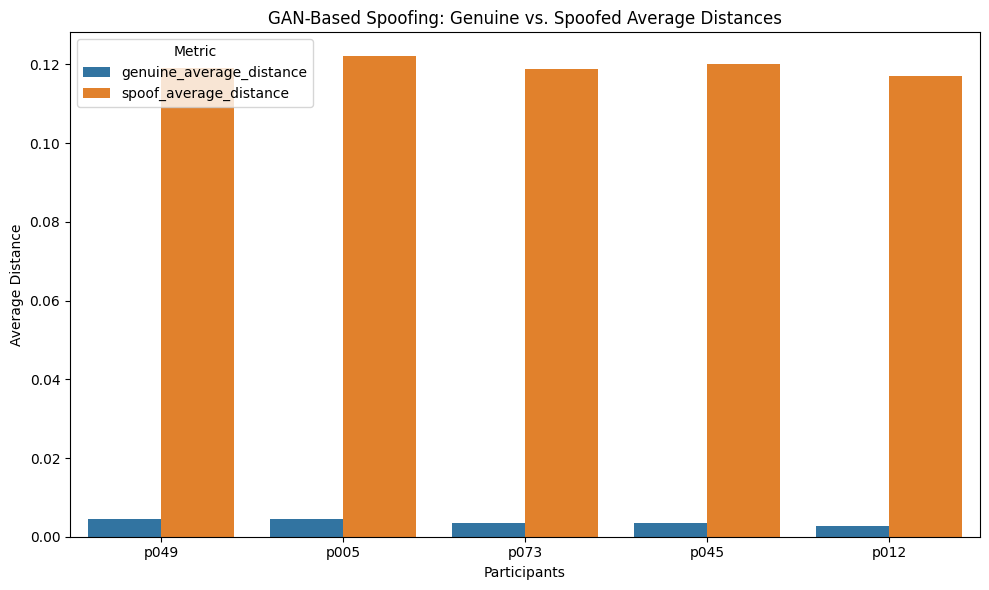

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Data Loading and Preprocessing
# ---------------------------

# Load the dataset with low_memory=False to suppress DtypeWarning
data = pd.read_csv('drive/MyDrive/Security_project/free-text.csv', low_memory=False)

# Strip extra spaces from column names
data.columns = data.columns.str.strip()

# Update keystroke features based on the corrected column names
keystroke_features = [
    "DU.key1.key1",
    "DD.key1.key2",
    "DU.key1.key2",
    "UD.key1.key2",
    "UU.key1.key2"
]

# Filter for selected participants
selected_users = ['p049', 'p005', 'p073', 'p045', 'p012']
filtered_data = data[data['participant'].isin(selected_users)].copy()

# Convert keystroke features to numeric, coercing errors
for feature in keystroke_features:
    filtered_data[feature] = pd.to_numeric(filtered_data[feature], errors='coerce')

# Drop rows with NaN values after conversion
filtered_data = filtered_data.dropna(subset=keystroke_features)

# Select keystroke features and convert to NumPy array
gan_training_data = filtered_data[keystroke_features].values

# Ensure data is in float format and normalize
gan_training_data = gan_training_data.astype('float32')
scaler = MinMaxScaler()
gan_training_data = scaler.fit_transform(gan_training_data)

# Verify Data Shape
print("GAN Training Data Shape:", gan_training_data.shape)

# ---------------------------
# Adjusted GAN Components
# ---------------------------

def build_generator(input_dim, output_dim):
    generator = Sequential([
        Input(shape=(input_dim,)),
        Dense(64),
        LeakyReLU(negative_slope=0.2),
        Dense(128),
        LeakyReLU(negative_slope=0.2),
        Dense(output_dim, activation='tanh')
    ])
    return generator

def build_discriminator(input_dim):
    discriminator = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        LeakyReLU(negative_slope=0.2),
        Dense(64),
        LeakyReLU(negative_slope=0.2),
        Dense(1, activation='sigmoid')
    ])
    return discriminator

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(generator.input_shape[1],))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=generator_optimizer, loss='binary_crossentropy')
    return gan

# ---------------------------
# Train GAN
# ---------------------------

def train_gan(generator, discriminator, gan_training_data, epochs=1000, batch_size=64):
    """
    Train the GAN with the given generator and discriminator.
    """
    # Compile the Discriminator
    discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Combine Generator and Discriminator into GAN
    gan = build_gan(generator, discriminator)

    # Training Loop
    for epoch in range(epochs):
        # Generate noise and create synthetic data
        noise = np.random.normal(0, 1, (batch_size, gan_training_data.shape[1]))
        generated_data = generator.predict(noise, verbose=0)

        # Get a random batch of real data
        idx = np.random.randint(0, gan_training_data.shape[0], batch_size)
        real_data = gan_training_data[idx]

        # Combine real and synthetic data
        combined_data = np.concatenate([real_data, generated_data])

        # Create labels for discriminator
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        labels = np.concatenate([real_labels, fake_labels])

        # Train the Discriminator
        discriminator.trainable = True
        metrics = discriminator.train_on_batch(combined_data, labels)
        d_loss = metrics[0]
        d_acc = metrics[1]

        # Train the Generator (via GAN) to fool the Discriminator
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, gan_training_data.shape[1]))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # Labels as 1 to fool the discriminator

        # Convert outputs to scalar floats
        if isinstance(d_loss, (tf.Tensor, np.ndarray, list)):
            d_loss = float(np.array(d_loss).flatten()[0])
        if isinstance(d_acc, (tf.Tensor, np.ndarray, list)):
            d_acc = float(np.array(d_acc).flatten()[0])
        if isinstance(g_loss, (tf.Tensor, np.ndarray, list)):
            g_loss = float(np.array(g_loss).flatten()[0])

        # Log progress
        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss:.4f} | D Acc: {d_acc:.4f} | G Loss: {g_loss:.4f}")

    return generator

# Adjusted Training Parameters
epochs = 1000  # Increased from 500 to 1000
batch_size = 64  # Increased from 32 to 64

# Define optimizers with different learning rates
generator_optimizer = Adam(learning_rate=0.0002)
discriminator_optimizer = Adam(learning_rate=0.0001)

# Initialize GAN components
input_dim = gan_training_data.shape[1]
generator = build_generator(input_dim=input_dim, output_dim=input_dim)
discriminator = build_discriminator(input_dim=input_dim)

# Train the GAN
trained_generator = train_gan(generator, discriminator, gan_training_data, epochs=epochs, batch_size=batch_size)

# ---------------------------
# Evaluate Spoofing
# ---------------------------

def evaluate_spoofing(data, keystroke_features, selected_users, generator):
    results = []
    for user in selected_users:
        user_data = data[data['participant'] == user][keystroke_features].values

        # Ensure data is in float format and normalize using the same scaler
        user_data = user_data.astype('float32')
        user_data = scaler.transform(user_data)

        # Split data into genuine and spoofed sets
        genuine_data = user_data[:len(user_data) // 2]
        spoofed_data = generator.predict(np.random.normal(0, 1, (len(genuine_data), generator.input_shape[1])), verbose=0)

        # Calculate distances for genuine and spoofed data
        genuine_distances = np.linalg.norm(genuine_data - genuine_data.mean(axis=0), axis=1)
        spoofed_distances = np.linalg.norm(spoofed_data - genuine_data.mean(axis=0), axis=1)

        # Calculate average distances
        genuine_average_distance = np.mean(genuine_distances)
        spoof_average_distance = np.mean(spoofed_distances)

        # Output results
        print(f"User: {user}")
        print(f"  Genuine Average Distance: {genuine_average_distance}")
        print(f"  Spoofed Average Distance: {spoof_average_distance}\n")

        results.append({
            'participant': user,
            'genuine_average_distance': genuine_average_distance,
            'spoof_average_distance': spoof_average_distance
        })
    return pd.DataFrame(results)

results_df = evaluate_spoofing(filtered_data, keystroke_features, selected_users, trained_generator)

# ---------------------------
# Visualization
# ---------------------------

# Melt the DataFrame for better visualization
results_melted = results_df.melt(id_vars='participant', var_name='Metric', value_name='Average Distance')

plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x='participant', y='Average Distance', hue='Metric')
plt.title("GAN-Based Spoofing: Genuine vs. Spoofed Average Distances")
plt.xlabel("Participants")
plt.ylabel("Average Distance")
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


### GAN - Phase II

GAN Training Data Shape: (33237, 5)
Epoch 0/1000 | D Loss: 0.6912 | D Acc: 0.5000 | G Loss: 0.6912


Epoch 100/1000 | D Loss: 0.6584 | D Acc: 0.5920 | G Loss: 0.6584
Epoch 200/1000 | D Loss: 0.6307 | D Acc: 0.6781 | G Loss: 0.6307
Epoch 300/1000 | D Loss: 0.6476 | D Acc: 0.6425 | G Loss: 0.6476
Epoch 400/1000 | D Loss: 0.6578 | D Acc: 0.6806 | G Loss: 0.6578
Epoch 500/1000 | D Loss: 0.6640 | D Acc: 0.6932 | G Loss: 0.6640
Epoch 600/1000 | D Loss: 0.6683 | D Acc: 0.7055 | G Loss: 0.6683
Epoch 700/1000 | D Loss: 0.6715 | D Acc: 0.7064 | G Loss: 0.6715
Epoch 800/1000 | D Loss: 0.6741 | D Acc: 0.6865 | G Loss: 0.6741
Epoch 900/1000 | D Loss: 0.6763 | D Acc: 0.6660 | G Loss: 0.6763
Epoch 999/1000 | D Loss: 0.6779 | D Acc: 0.6491 | G Loss: 0.6779
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User: p049
  Genuine Accuracy: 0.9977
  Spoof Accuracy: 1.0000

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
User: p005
  Genuine Accuracy: 0.9985
  Spoof Accuracy: 1.0000

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
104/104 ━━━━━━━━━

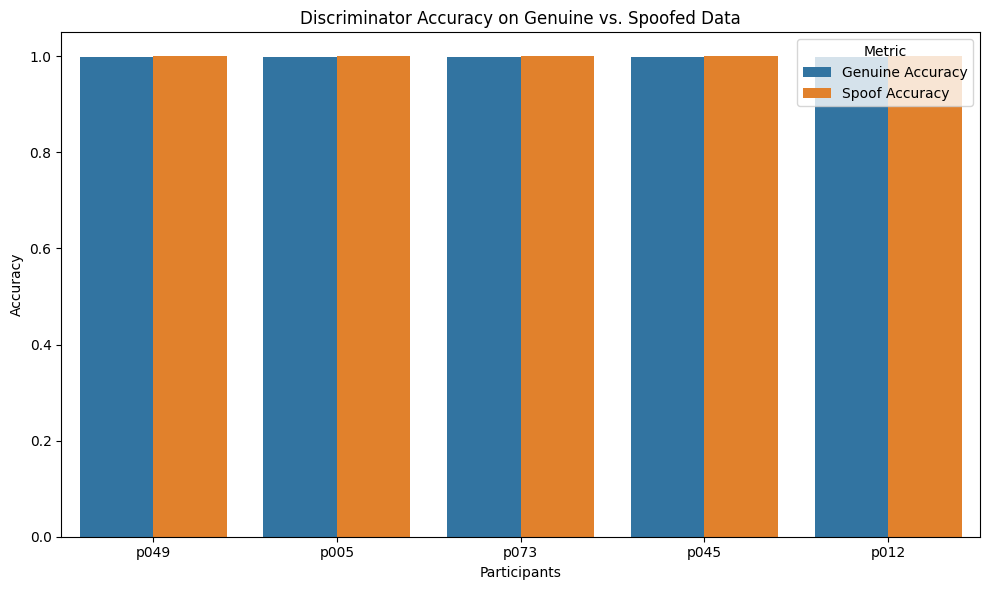

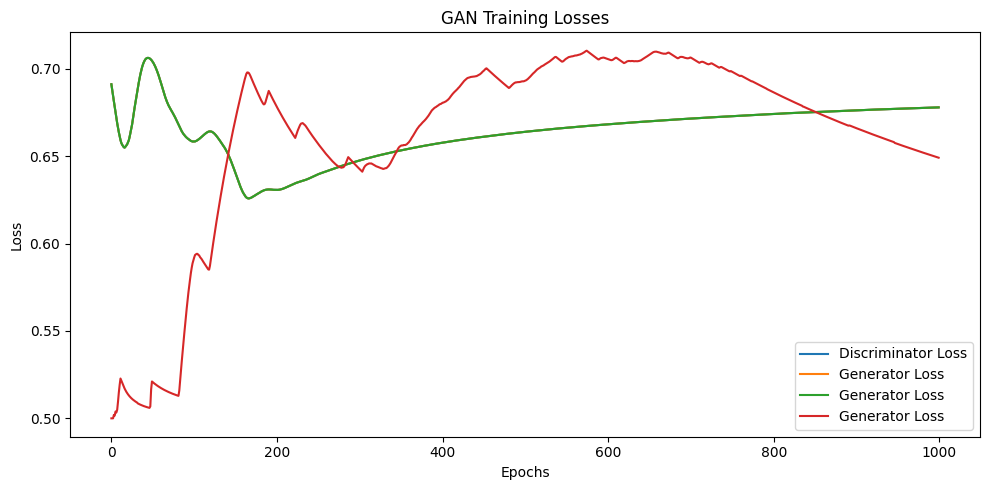

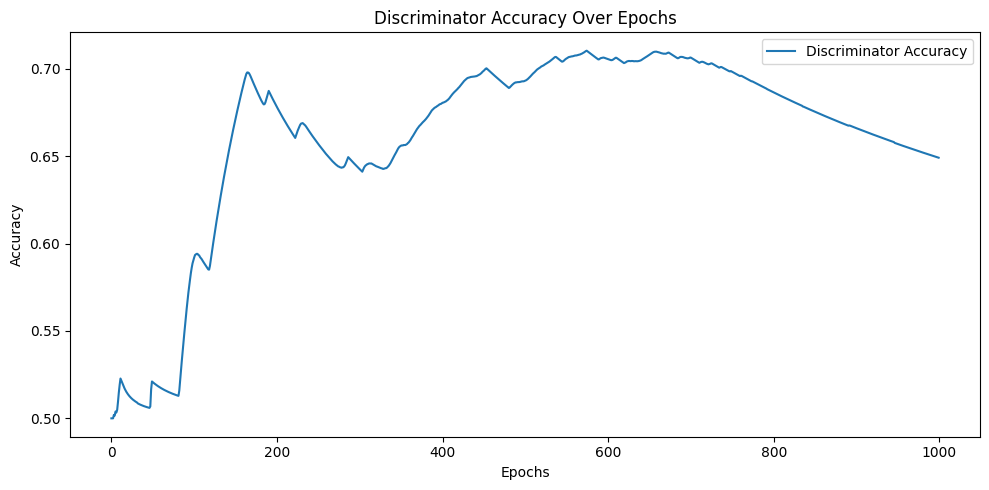

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Data Loading and Preprocessing
# ---------------------------

# Load the dataset with low_memory=False to suppress DtypeWarning
data = pd.read_csv('drive/MyDrive/Security_project/free-text.csv', low_memory=False)

# Strip extra spaces from column names
data.columns = data.columns.str.strip()

# Update keystroke features based on the corrected column names
keystroke_features = [
    "DU.key1.key1",
    "DD.key1.key2",
    "DU.key1.key2",
    "UD.key1.key2",
    "UU.key1.key2"
]

# Filter for selected participants
selected_users = ['p049', 'p005', 'p073', 'p045', 'p012']
filtered_data = data[data['participant'].isin(selected_users)].copy()

# Convert keystroke features to numeric, coercing errors
for feature in keystroke_features:
    filtered_data[feature] = pd.to_numeric(filtered_data[feature], errors='coerce')

# Drop rows with NaN values after conversion
filtered_data = filtered_data.dropna(subset=keystroke_features)

# Select keystroke features and convert to NumPy array
gan_training_data = filtered_data[keystroke_features].values

# Ensure data is in float format and normalize
gan_training_data = gan_training_data.astype('float32')
scaler = MinMaxScaler()
gan_training_data = scaler.fit_transform(gan_training_data)

# Verify Data Shape
print("GAN Training Data Shape:", gan_training_data.shape)

# ---------------------------
# Adjusted GAN Components
# ---------------------------

def build_generator(input_dim, output_dim):
    generator = Sequential([
        Input(shape=(input_dim,)),
        Dense(256),
        LeakyReLU(negative_slope=0.2),
        Dense(512),
        LeakyReLU(negative_slope=0.2),
        Dense(256),
        LeakyReLU(negative_slope=0.2),
        Dense(output_dim, activation='tanh')
    ])
    return generator

def build_discriminator(input_dim):
    discriminator = Sequential([
        Dense(256),
        LeakyReLU(negative_slope=0.2),
        Dense(512),
        LeakyReLU(negative_slope=0.2),
        Dense(256),
        LeakyReLU(negative_slope=0.2),
        Dense(1, activation='sigmoid')
    ])
    return discriminator

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(generator.input_shape[1],))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=generator_optimizer, loss='binary_crossentropy')
    return gan

# ---------------------------
# Train GAN
# ---------------------------

def train_gan(generator, discriminator, gan_training_data, epochs=1000, batch_size=64):
    """
    Train the GAN with the given generator and discriminator.
    """
    # Compile the Discriminator
    discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Combine Generator and Discriminator into GAN
    gan = build_gan(generator, discriminator)

    # Lists to store losses and accuracies
    d_losses = []
    g_losses = []
    d_accuracies = []

    # Training Loop
    for epoch in range(epochs):
        # Generate noise and create synthetic data
        noise = np.random.normal(0, 1, (batch_size, gan_training_data.shape[1]))
        generated_data = generator.predict(noise, verbose=0)

        # Get a random batch of real data
        idx = np.random.randint(0, gan_training_data.shape[0], batch_size)
        real_data = gan_training_data[idx]

        # Combine real and synthetic data
        combined_data = np.concatenate([real_data, generated_data])

        # Create labels for discriminator
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        labels = np.concatenate([real_labels, fake_labels])

        # Train the Discriminator
        discriminator.trainable = True
        metrics = discriminator.train_on_batch(combined_data, labels)
        d_loss = metrics[0]
        d_acc = metrics[1]

        # Store discriminator loss and accuracy
        d_losses.append(d_loss)
        d_accuracies.append(d_acc)

        # Train the Generator (via GAN) to fool the Discriminator
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, gan_training_data.shape[1]))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # Labels as 1 to fool the discriminator

        # Store generator loss
        g_losses.append(g_loss)

        # Convert outputs to scalar floats
        if isinstance(d_loss, (tf.Tensor, np.ndarray, list)):
            d_loss = float(np.array(d_loss).flatten()[0])
        if isinstance(d_acc, (tf.Tensor, np.ndarray, list)):
            d_acc = float(np.array(d_acc).flatten()[0])
        if isinstance(g_loss, (tf.Tensor, np.ndarray, list)):
            g_loss = float(np.array(g_loss).flatten()[0])

        # Log progress
        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss:.4f} | D Acc: {d_acc:.4f} | G Loss: {g_loss:.4f}")

    return generator, d_losses, g_losses, d_accuracies

# Adjusted Training Parameters
epochs = 1000  # Increased from 500 to 1000
batch_size = 64  # Increased from 32 to 64

# Define optimizers with different learning rates
generator_optimizer = Adam(learning_rate=0.0002)
discriminator_optimizer = Adam(learning_rate=0.0001)

# Initialize GAN components
input_dim = gan_training_data.shape[1]
generator = build_generator(input_dim=input_dim, output_dim=input_dim)
discriminator = build_discriminator(input_dim=input_dim)

# Train the GAN
trained_generator, d_losses, g_losses, d_accuracies = train_gan(generator, discriminator, gan_training_data, epochs=epochs, batch_size=batch_size)

# ---------------------------
# Evaluate Spoofing Accuracy
# ---------------------------

def evaluate_spoofing_accuracy(data, keystroke_features, selected_users, generator, discriminator):
    results = []
    for user in selected_users:
        user_data = data[data['participant'] == user][keystroke_features].values

        # Ensure data is in float format and normalize using the same scaler
        user_data = user_data.astype('float32')
        user_data = scaler.transform(user_data)

        # Split data into genuine and spoofed sets
        genuine_data = user_data[:len(user_data) // 2]
        spoofed_data = generator.predict(np.random.normal(0, 1, (len(genuine_data), generator.input_shape[1])), verbose=0)

        # Labels
        genuine_labels = np.ones((len(genuine_data), 1))
        spoofed_labels = np.zeros((len(spoofed_data), 1))

        # Discriminator predictions
        discriminator.trainable = False  # Ensure the discriminator is not training
        genuine_predictions = discriminator.predict(genuine_data)
        spoofed_predictions = discriminator.predict(spoofed_data)

        # Binarize predictions (0 or 1)
        genuine_predictions_binary = (genuine_predictions >= 0.5).astype(int)
        spoofed_predictions_binary = (spoofed_predictions < 0.5).astype(int)  # Invert for spoofed data

        # Calculate accuracy
        genuine_accuracy = np.mean(genuine_predictions_binary == genuine_labels)
        spoof_accuracy = np.mean(spoofed_predictions_binary == spoofed_labels)

        # Output results
        print(f"User: {user}")
        print(f"  Genuine Accuracy: {genuine_accuracy:.4f}")
        print(f"  Spoof Accuracy: {spoof_accuracy:.4f}\n")

        results.append({
            'participant': user,
            'Genuine Accuracy': genuine_accuracy,
            'Spoof Accuracy': spoof_accuracy
        })
    return pd.DataFrame(results)

accuracy_df = evaluate_spoofing_accuracy(filtered_data, keystroke_features, selected_users, trained_generator, discriminator)

# ---------------------------
# Visualization of Accuracy
# ---------------------------

# Melt the DataFrame for better visualization
accuracy_melted = accuracy_df.melt(id_vars='participant', var_name='Metric', value_name='Accuracy')

plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_melted, x='participant', y='Accuracy', hue='Metric')
plt.title("Discriminator Accuracy on Genuine vs. Spoofed Data")
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# ---------------------------
# Visualization of Losses and Accuracies Over Epochs
# ---------------------------

# Plot Discriminator and Generator Losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('GAN Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Discriminator Accuracy Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## END